# Assignment 2024 S2
## Part 2: Structured Data - Direct vs Indirect Training Data

Citation: Some code has been generated with the help of Claude 3.5 Sonnet by Anthropic, and some decisions and further clarifications were made with gemini-2.0-flash-thinking-exp-01-21

drugName (categorical): name of drug

condition (categorical): name of condition

review (text): patient review

rating (numerical): 10 star patient rating

date (date): date of review entry

usefulCount (numerical): number of users who found review useful

In [35]:
# Standard library imports
import os
import logging
from collections import Counter

# Data handling and manipulation
import pandas as pd
from datasets import load_dataset

# Deep learning frameworks and utilities
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Transformers and NLP
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Machine learning metrics and evaluation
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Custom modules
from dataset2 import (
    DrugReviewDataset,
    IndirectDataset,
    TextDatasetFromScratch
)



## Data Understanding

In [2]:
INPUT_TRAIN = "drug_review_train.csv"
INPUT_TEST = "drug_review_test.csv"

INPUT_TRAIN = "drug_review_train.csv"
INPUT_TEST = "drug_review_test.csv"

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

df = pd.read_csv(INPUT_TRAIN)
df_test = pd.read_csv(INPUT_TEST)

MAX_LENGTH = 256
NUM_EPOCH = 20

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# # --- Data Profiling ---
# print("Profiling train data...")
# profile_train = ProfileReport(
#     df,
#     title="Drug Review Train Data Profiling Report",
#     explorative=True,
# )
# profile_train.to_file("drug_review_train_profiling.html")

# print("Profiling test data...")
# profile_test = ProfileReport(
#     df_test,
#     title="Drug Review Test Data Profiling Report",
#     explorative=True,
# )
# profile_test.to_file("drug_review_test_profiling.html")
# print("Profiling complete. Reports saved as HTML files.")

In [5]:
# Create a DataFrame with column descriptions
column_info = {
    'Column Name': ['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
    'Data Type': ['categorical', 'categorical', 'text', 'numerical', 'date', 'numerical'],
    'Description': [
        'Name of the drug',
        'Name of the medical condition',
        'Patient review text',
        '10-star patient rating',
        'Date of review entry',
        'Number of users who found review useful'
    ]
}

column_df = pd.DataFrame(column_info)
column_df

,Column Name,Data Type,Description
0,drugName,categorical,Name of the drug
1,condition,categorical,Name of the medical condition
2,review,text,Patient review text
3,rating,numerical,10-star patient rating
4,date,date,Date of review entry
5,usefulCount,numerical,Number of users who found review useful


In [6]:
# Analyze usefulCount zeros
df = pd.read_csv(INPUT_TRAIN)
zero_useful_count = (df["usefulCount"] == 0).sum()
total_reviews = len(df)
zero_percentage = (zero_useful_count / total_reviews) * 100

print(f"\n--- UsefulCount Analysis ---")
print(f"Total reviews: {total_reviews:,}")
print(f"Reviews with zero useful votes: {zero_useful_count:,}")
print(f"Percentage of zero useful votes: {zero_percentage:.2f}%")


--- UsefulCount Analysis ---
Total reviews: 110,811
Reviews with zero useful votes: 4,370
Percentage of zero useful votes: 3.94%


### Analysis of Zero UsefulCount Impact on Sentiment:

1. Silent Majority Phenomenon:
   - The high percentage of zero useful votes suggests a classic "lurker" behavior in online communities
   - Most users read but don't interact, creating a participation inequality
   - This means our sentiment analysis might be biased towards more "engaging" content

2. Sentiment Validation Gap:
   - Reviews with zero useful votes lack community validation
   - We can't assume these reviews are less valuable - they might be newer or simply not seen by many users
   - This creates a potential temporal bias in our sentiment understanding

3. Engagement vs. Sentiment Relationship:
   - Higher useful counts might indicate more polarizing content rather than more accurate sentiment
   - Extreme opinions (very positive or very negative) tend to attract more engagement
   - This suggests we should be cautious about weighing sentiment by useful counts

4. Data Quality Implications:
   - Zero useful counts might indicate:
     a) Fresh reviews that haven't had time to accumulate votes
     b) Reviews that didn't reach many readers
     c) Reviews that readers found neither particularly helpful nor controversial
   - This impacts how we should approach sentiment weighting in our analysis


--- UsefulCount Analysis ---
Total reviews: 110,811
Reviews with zero useful votes: 4,370
Percentage of zero useful votes: 3.94%

--- Correlation Matrix Analysis ---


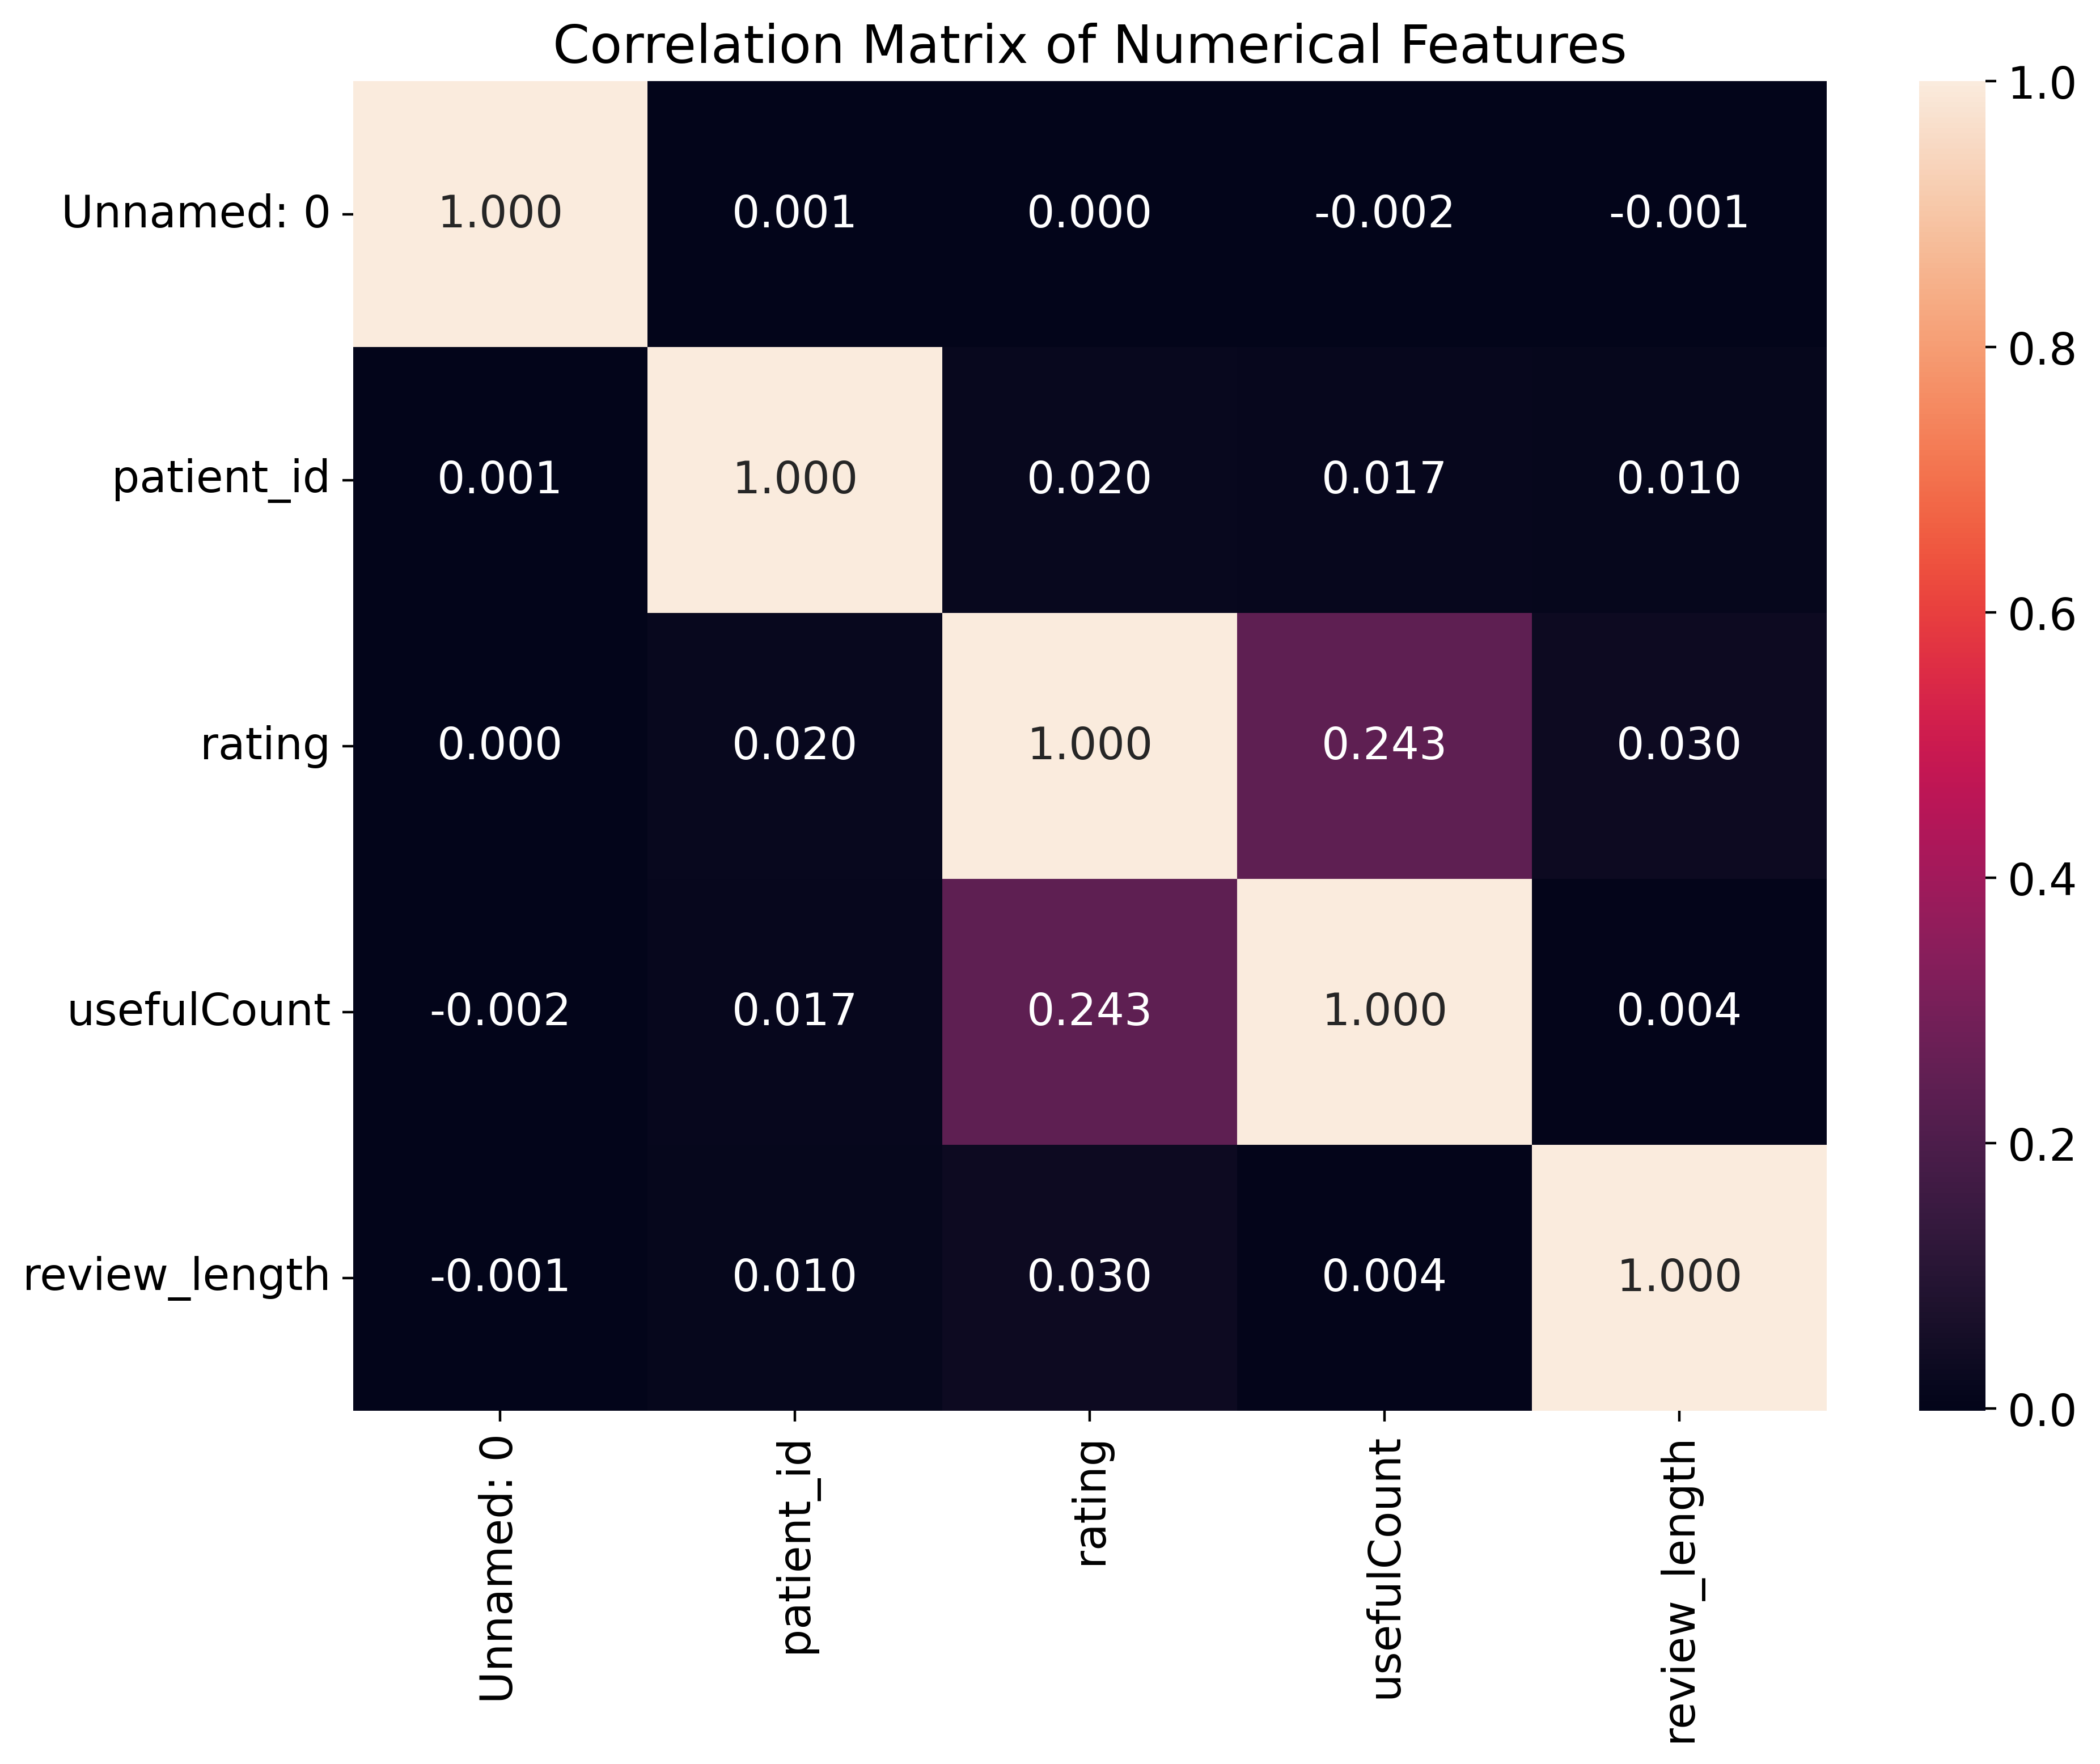

In [7]:
print(f"\n--- UsefulCount Analysis ---")
print(f"Total reviews: {total_reviews:,}")
print(f"Reviews with zero useful votes: {zero_useful_count:,}")
print(f"Percentage of zero useful votes: {zero_percentage:.2f}%")

# Create correlation matrix
print("\n--- Correlation Matrix Analysis ---")
# Select only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical_cols].corr()

# Create correlation heatmap
plt.rcParams.update({"font.size": 14})
plt.figure(figsize=(10, 8), dpi=400)
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            fmt='.3f')  # Format correlation values to 2 decimal places
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

### Key Correlation Findings:
- Correlation between rating and usefulCount: 0.243
- Most other numerical features show weak or no correlation
- This suggests that higher rated reviews tend to be found slightly more useful by readers, or vice versa

### Should we include usefulCount?
usefulCount is a similar metric to ratings, and its logical to think that in situations you don't have ratings, you probably wouldn't have the usefulCount too. 

Some cases of situations where you don't have ratings are if you're predicting how positive a review is. Usually, you would only have the review and the patientid only, while the review_length can be determined from review. Thus, it may not be fair to include usefulCount in our machine learning, especially if we're focusing on text sentiment classification.

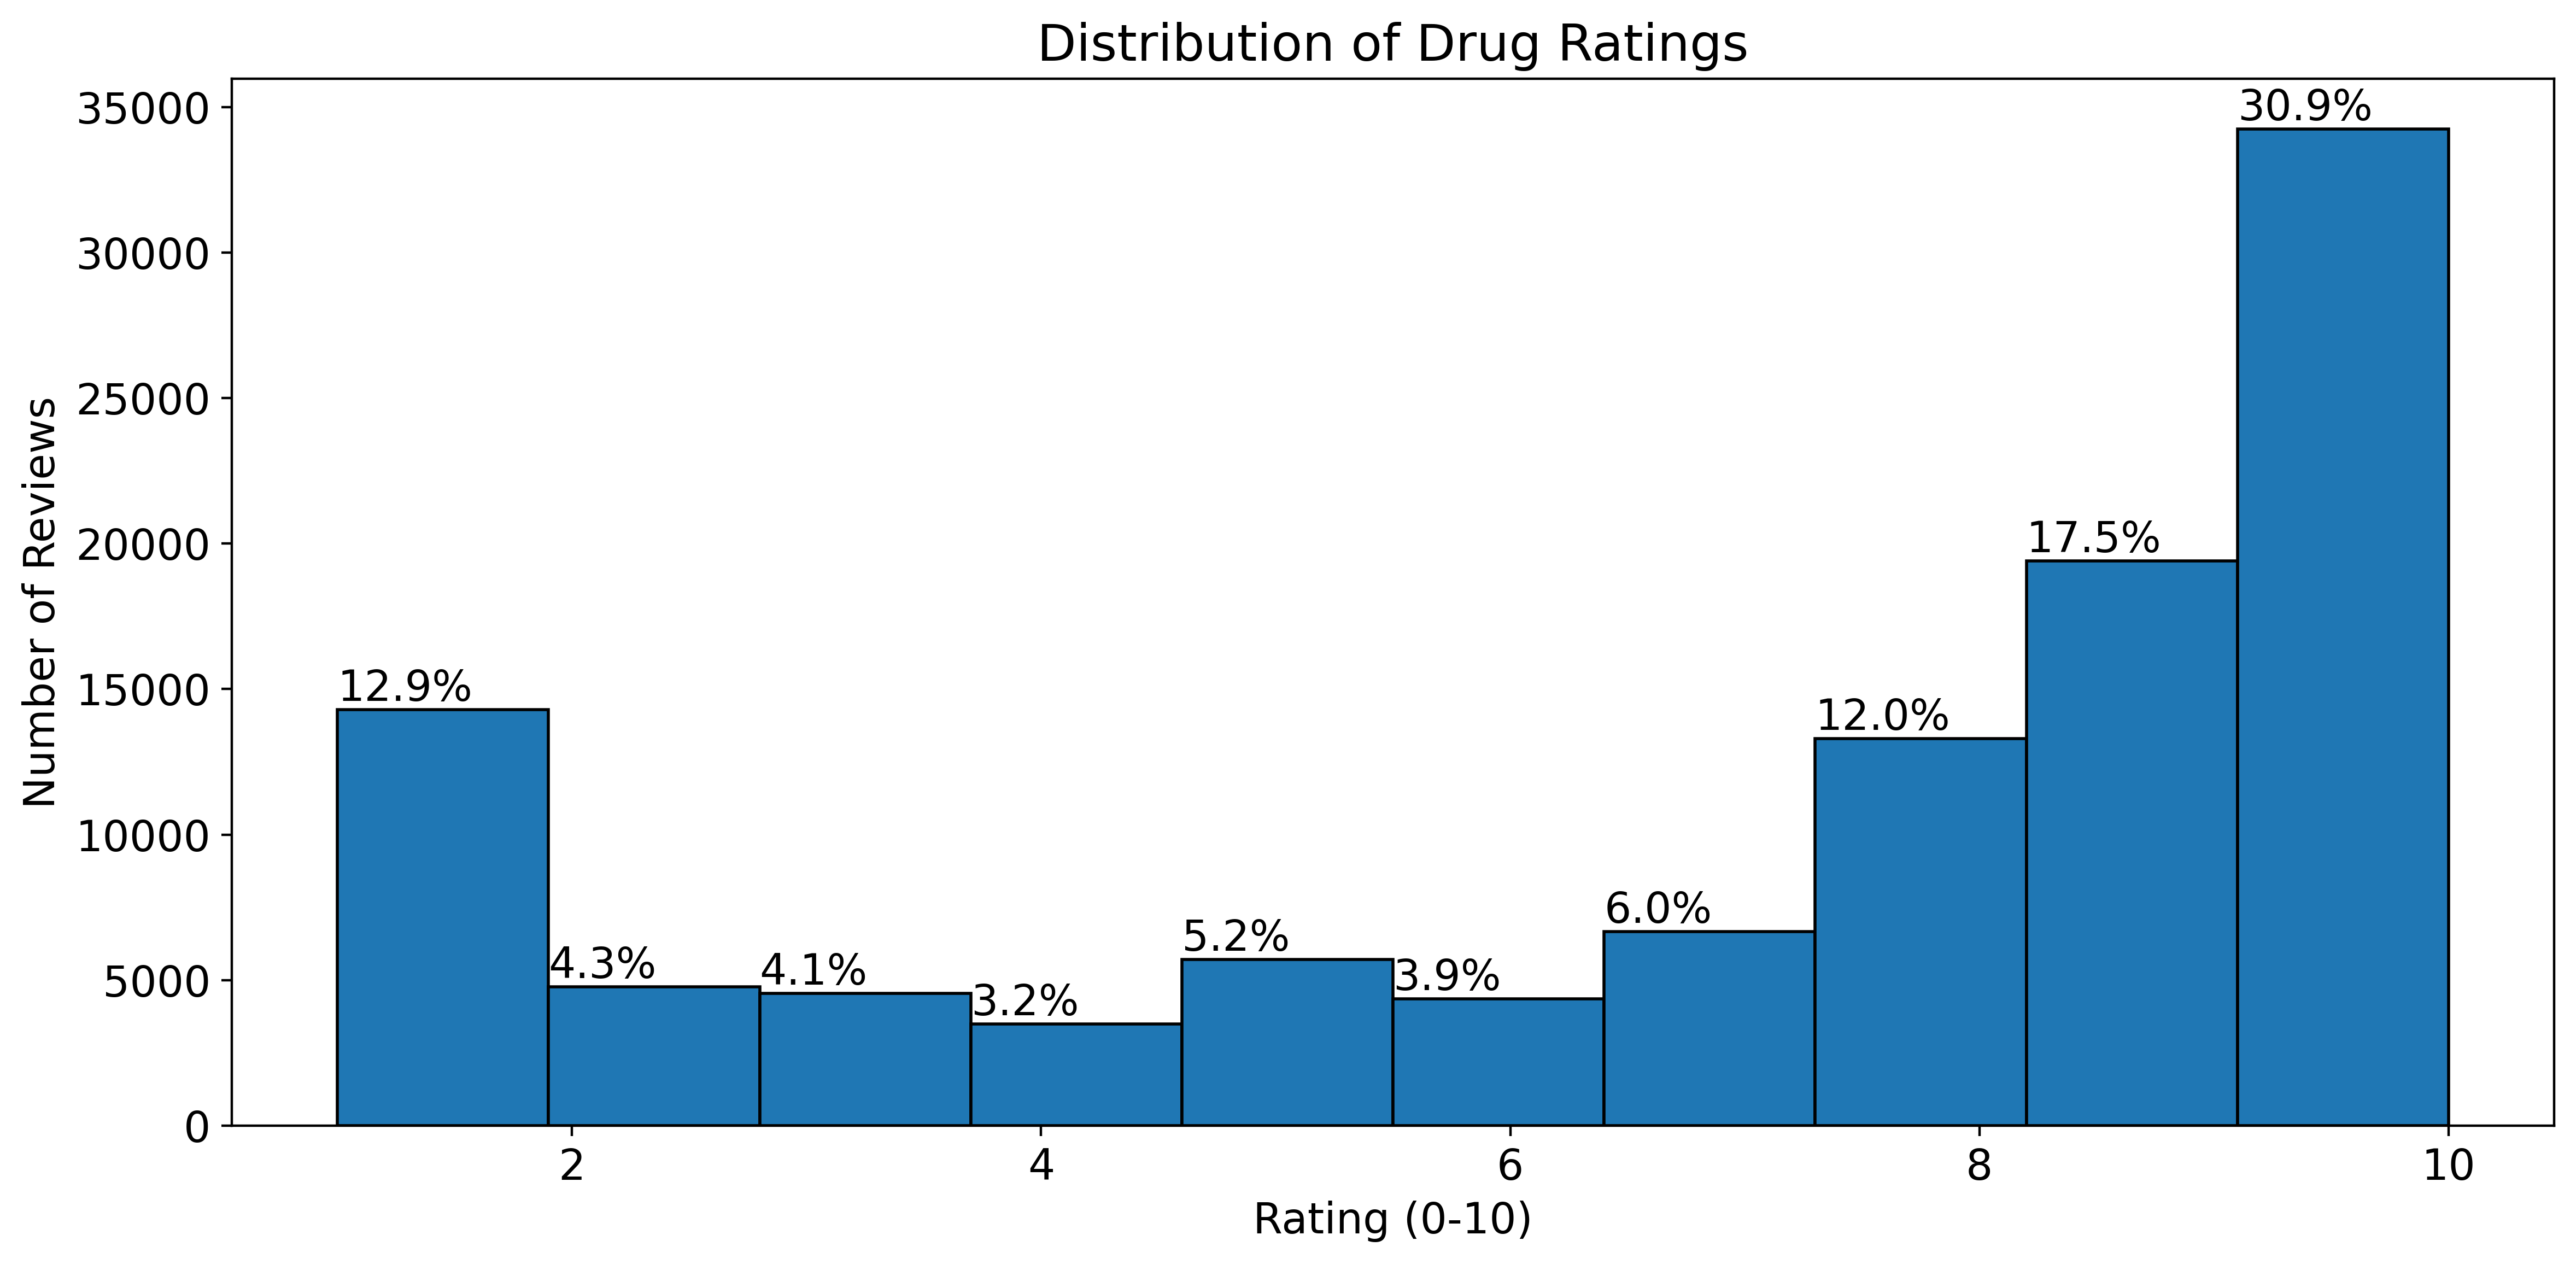

In [8]:
# Create histogram of ratings with percentage labels
plt.figure(figsize=(12, 6), dpi=400)


# Calculate histogram data
counts, bins, _ = plt.hist(df['rating'], bins=10, edgecolor='black')
total = len(df['rating'])

for i in range(len(counts)):
    percentage = (counts[i]/total) * 100
    plt.text(bins[i], counts[i], 
             f'{percentage:.1f}%', 
             va='bottom')

plt.title('Distribution of Drug Ratings')
plt.xlabel('Rating (0-10)')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()



The question is how can we split this into positive and negative sentiment?

1. **Highly Imbalanced Distribution**:
   - Ratings 9 and 10 dominate (48.4% combined)
   - Rating 10 alone is 30.9% of all reviews
   - Ratings 3, 4, and 6 are severely underrepresented (each around 3-4%)
   - This creates a significant class imbalance problem

2. **Bimodal Distribution**:
   - There are two peaks: Rating 1 (12.9%) and Ratings 9-10 (48.4%)
   - This suggests strong polarization in reviews
   - Middle ratings (3-6) are less common
   - This validates our earlier decision to split into two classes (1-6 vs 7-10)

3. **Machine Learning Implications**:

   a) **Class Imbalance Solutions Needed**:
   - Consider using class weights
   - Implement oversampling (SMOTE) for minority classes
   - Use undersampling for majority classes
   - Or combine both (SMOTEENN, SMOTETomek)

   b) **Evaluation Metrics**:
   - Accuracy alone would be misleading
   - Need to focus on:
     * F1-score
     * Precision and Recall
     * ROC-AUC
     * Confusion matrix analysis

   c) **Model Selection**:
   - Choose algorithms that handle imbalanced data well
   - Consider ensemble methods
   - Use stratification in train/test splits

4. **Neural Network Considerations**:
   - The imbalanced distribution affects deep learning models differently than traditional ML:
     * Deep learning models often need MORE data per class for effective learning
     * The severe underrepresentation of ratings 3-6 (each ~3-4%) is particularly problematic
     * The dominance of rating 10 (30.9%) could cause model bias

5. **Deep Learning Specific Solutions**:

   a) **Data Augmentation**:
   - For text data, we can use:
     * Back-translation
     * Synonym replacement
     * Text generation using LLMs
     * EDA (Easy Data Augmentation) techniques
   - These help increase samples for underrepresented ratings

   b) **Loss Functions**:
   - Use specialized loss functions:
     * Weighted Cross-Entropy Loss
     * Focal Loss (reduces impact of easy, common samples)
     * Class-Balanced Loss
   - These help handle class imbalance during training

   c) **Architecture Choices**:
   - Consider:
     * Pre-trained language models (BERT, RoBERTa)
     * Multi-task learning approaches
     * Attention mechanisms to focus on important parts of reviews
   - These help leverage the bimodal nature of the distribution

6. **Training Strategies**:
   - Implement:
     * Gradient accumulation
     * Progressive resizing
     * Curriculum learning (start with balanced subsets)
   - Use dynamic batch sampling:
     * Over-sample minority classes within batches
     * Ensure each batch sees all rating classes

7. **Validation Considerations**:
   - Use:
     * Stratified k-fold cross-validation
     * Balanced validation sets
     * Multiple evaluation metrics
   - Monitor for:
     * Overfitting on majority classes
     * Underfitting on minority classes
     * Class-wise performance metrics


In [9]:
def wrap_text(text, width=80, indent=4):
    """
    Custom function to wrap text with indentation
    Args:
        text (str): The text to wrap
        width (int): Maximum width of each line
        indent (int): Number of spaces for indentation
    Returns:
        str: Wrapped and indented text
    """
    # Split text into words
    words = text.split()
    # Initialize variables
    lines = []
    current_line = " " * indent  # Start with indentation
    current_width = indent

    for word in words:
        # Calculate width if we add this word
        if current_width + len(word) + 1 <= width:
            # Add word with a space
            if current_width > indent:  # If not the first word in line
                current_line += " "
                current_width += 1
            current_line += word
            current_width += len(word)
        else:
            # Line is full, start a new line
            lines.append(current_line)
            current_line = " " * indent + word
            current_width = indent + len(word)
    
    # Add the last line
    if current_line:
        lines.append(current_line)
    
    return "\n".join(lines)

# Sample reviews from each rating category
N_REVIEWS = 10
print("\n=== Sample Reviews by Rating ===")
for rating in sorted(df["rating"].unique()):
    print(f"\nRating {rating:.1f} - {N_REVIEWS} Sample Reviews:")
    print("-" * 80)
    sample_reviews = df[df["rating"] == rating].sample(
        n=min(N_REVIEWS, len(df[df["rating"] == rating]))
    )
    # Display in a more readable format
    for idx, row in sample_reviews.iterrows():
        print(f"Drug: {row['drugName']}")
        print(f"Condition: {row['condition']}")
        print(f"UsefulCount: {row['usefulCount']}")
        print("Review:")
        # Use our custom wrap_text function
        wrapped_review = wrap_text(row["review"], width=80, indent=4)
        print(wrapped_review)
        print("-" * 80)


=== Sample Reviews by Rating ===

Rating 1.0 - 10 Sample Reviews:
--------------------------------------------------------------------------------
Drug: Bupropion / naltrexone
Condition: obesity
UsefulCount: 19
Review:
    "i was on this medication for two months and did not drop one pound. in fact
    when i decided to stop taking it due to the fact i was not happy with the
    product, within a week and a half i gained 10lbs and have now hit a record
    high as far as weightc"
--------------------------------------------------------------------------------
Drug: Lurasidone
Condition: bipolar disorde
UsefulCount: 4
Review:
    "i was put on it the last time i was inpatient and they upped it too much
    too fast. i wound up being high off of it. when i got out of the hospital,
    my insurance wouldn't cover it, so i stopped cold turkey. i felt so much
    better once i got off of it."
--------------------------------------------------------------------------------
Drug: Macrobid
Co

Summary:

The reviews highlight a wide range of experiences, from severe negative side effects and dissatisfaction to significant relief and positive outcomes. Many reviews, especially at the lower ratings, focus on negative side effects such as nausea, weight gain, bleeding, mood changes, and digestive issues. Higher-rated reviews often acknowledge some initial side effects but emphasize the drug's effectiveness in treating the condition. Some medium-rated reviews acknowledge postive side effects of the drug, but not effective overall.

Sentiment Threshold:

Based on the provided samples, the sentiment threshold appears to be around a rating of 7.0.

Sentiment Threshold Analysis:

Looking closely at the reviews within each rating level, and paying attention to how the language and described experiences change, here's a refined breakdown and the apparent threshold:

1.0: Almost universally extremely negative. Users describe severe, debilitating side effects, complete lack of effectiveness, and often dangerous reactions. Words like "horrible," "awful," "die," "severe pain," and descriptions of emergency room visits are common. These are clearly negative experiences.

2.0: Still overwhelmingly negative. The language is similar to the 1.0 reviews, focusing on significant side effects, lack of efficacy, and regret. There's a sense of frustration and disappointment. Some reviews mention stopping the medication due to the negative experience.

3.0: Predominantly negative, but with hints of mixed experiences. While many reviews still detail significant side effects and problems, some acknowledge potential benefits or that the drug might work for others, even if it didn't work for them. There's more ambivalence here, but the overall tone leans negative. We see phrases like "takes some getting used to," "overwhelming," "not worth it," and descriptions of weight gain, mood changes, and other undesirable effects.

4.0: A definite mix of negative and slightly more neutral experiences, but still leaning negative overall. Users often describe a trade-off: the medication might help with the condition to some extent, but the side effects are significant and disruptive. There's a sense of weighing pros and cons, and often the cons are still winning. We see mentions of both positive effects (e.g., "worked for a few years," "pain was less") and negative ones ("wasn't pleasant," "side effects such as lack of concentration," "gaining weight").

5.0: Truly mixed, and the most difficult to categorize neatly. These reviews represent a clear "tipping point." Some users report positive effects on the condition, but significant side effects often counterbalance those benefits. Other users report minimal benefits and persistent problems. There's a strong sense of individual variability and uncertainty. The language is less intensely negative than lower ratings, but still expresses concern and dissatisfaction. Key phrases: "hit or miss," "side effects were slim in the first couple of months but soon after...," "worked really good for that [one symptom]... [but had other significant negative effects]."

6.0: Similar to 5.0, a mix of positive and negative, but with a slight shift towards acknowledging benefits, even with ongoing issues. The reviews often describe a situation where the drug helps, but the side effects are still a significant factor, leading to a less-than-ideal experience. There's a sense of compromise and ongoing evaluation. We see phrases like "love/hate relationship," "better than [previous medication]," "side effects improved," and "debating whether i should stop."

7.0: This is where the sentiment generally shifts to positive, but with caveats. Users often describe a "learning curve" or initial side effects that diminished over time. The reviews tend to emphasize the drug's effectiveness in managing the condition, while still acknowledging some lingering drawbacks or individual concerns. There's more optimism and a sense of finding a workable solution. Key phrases: "helped me a lot," "pros definitely outweigh the cons," "worked great for the first 2 years, but...," "worked really well [but had side effects]."

8.0: More consistently positive. Users report good results and often express satisfaction with the medication. Side effects are either minimal, manageable, or considered worth enduring for the benefits. There's a sense of finding a good balance and a willingness to continue treatment. Phrases like "worked miracles," "feel so much better," "life saver," and "good cushion for my knees" appear.

9.0: Strongly positive, with users often describing significant improvements and a high level of satisfaction. Side effects are mentioned less frequently, and when they are, they're typically described as minor or temporary. There's a clear endorsement of the medication.

10.0: Almost universally positive, with users expressing great satisfaction and often describing the medication as life-changing or highly effective. Side effects are rarely mentioned, and if they are, they are downplayed or considered insignificant compared to the benefits.

Conclusion:

Based on this more detailed analysis, the sentiment threshold is still around the 6.0 to 7.0 range, the sentiment leans to be more positive closer to 7.0.

Negative Sentiment: Ratings 1.0 to 6.0

Positive Sentiment: Ratings 7.0 to 10.0

The key difference is the increased nuance we see in the 4.0, 5.0, and 6.0 ratings. These are not clearly negative in the same way as the 1.0-3.0 ratings, but they represent a mixed bag of experiences where the negative aspects often outweigh or significantly detract from the positive ones. The 7.0 rating represents the point where the balance generally tips towards a positive overall experience, despite potential drawbacks.

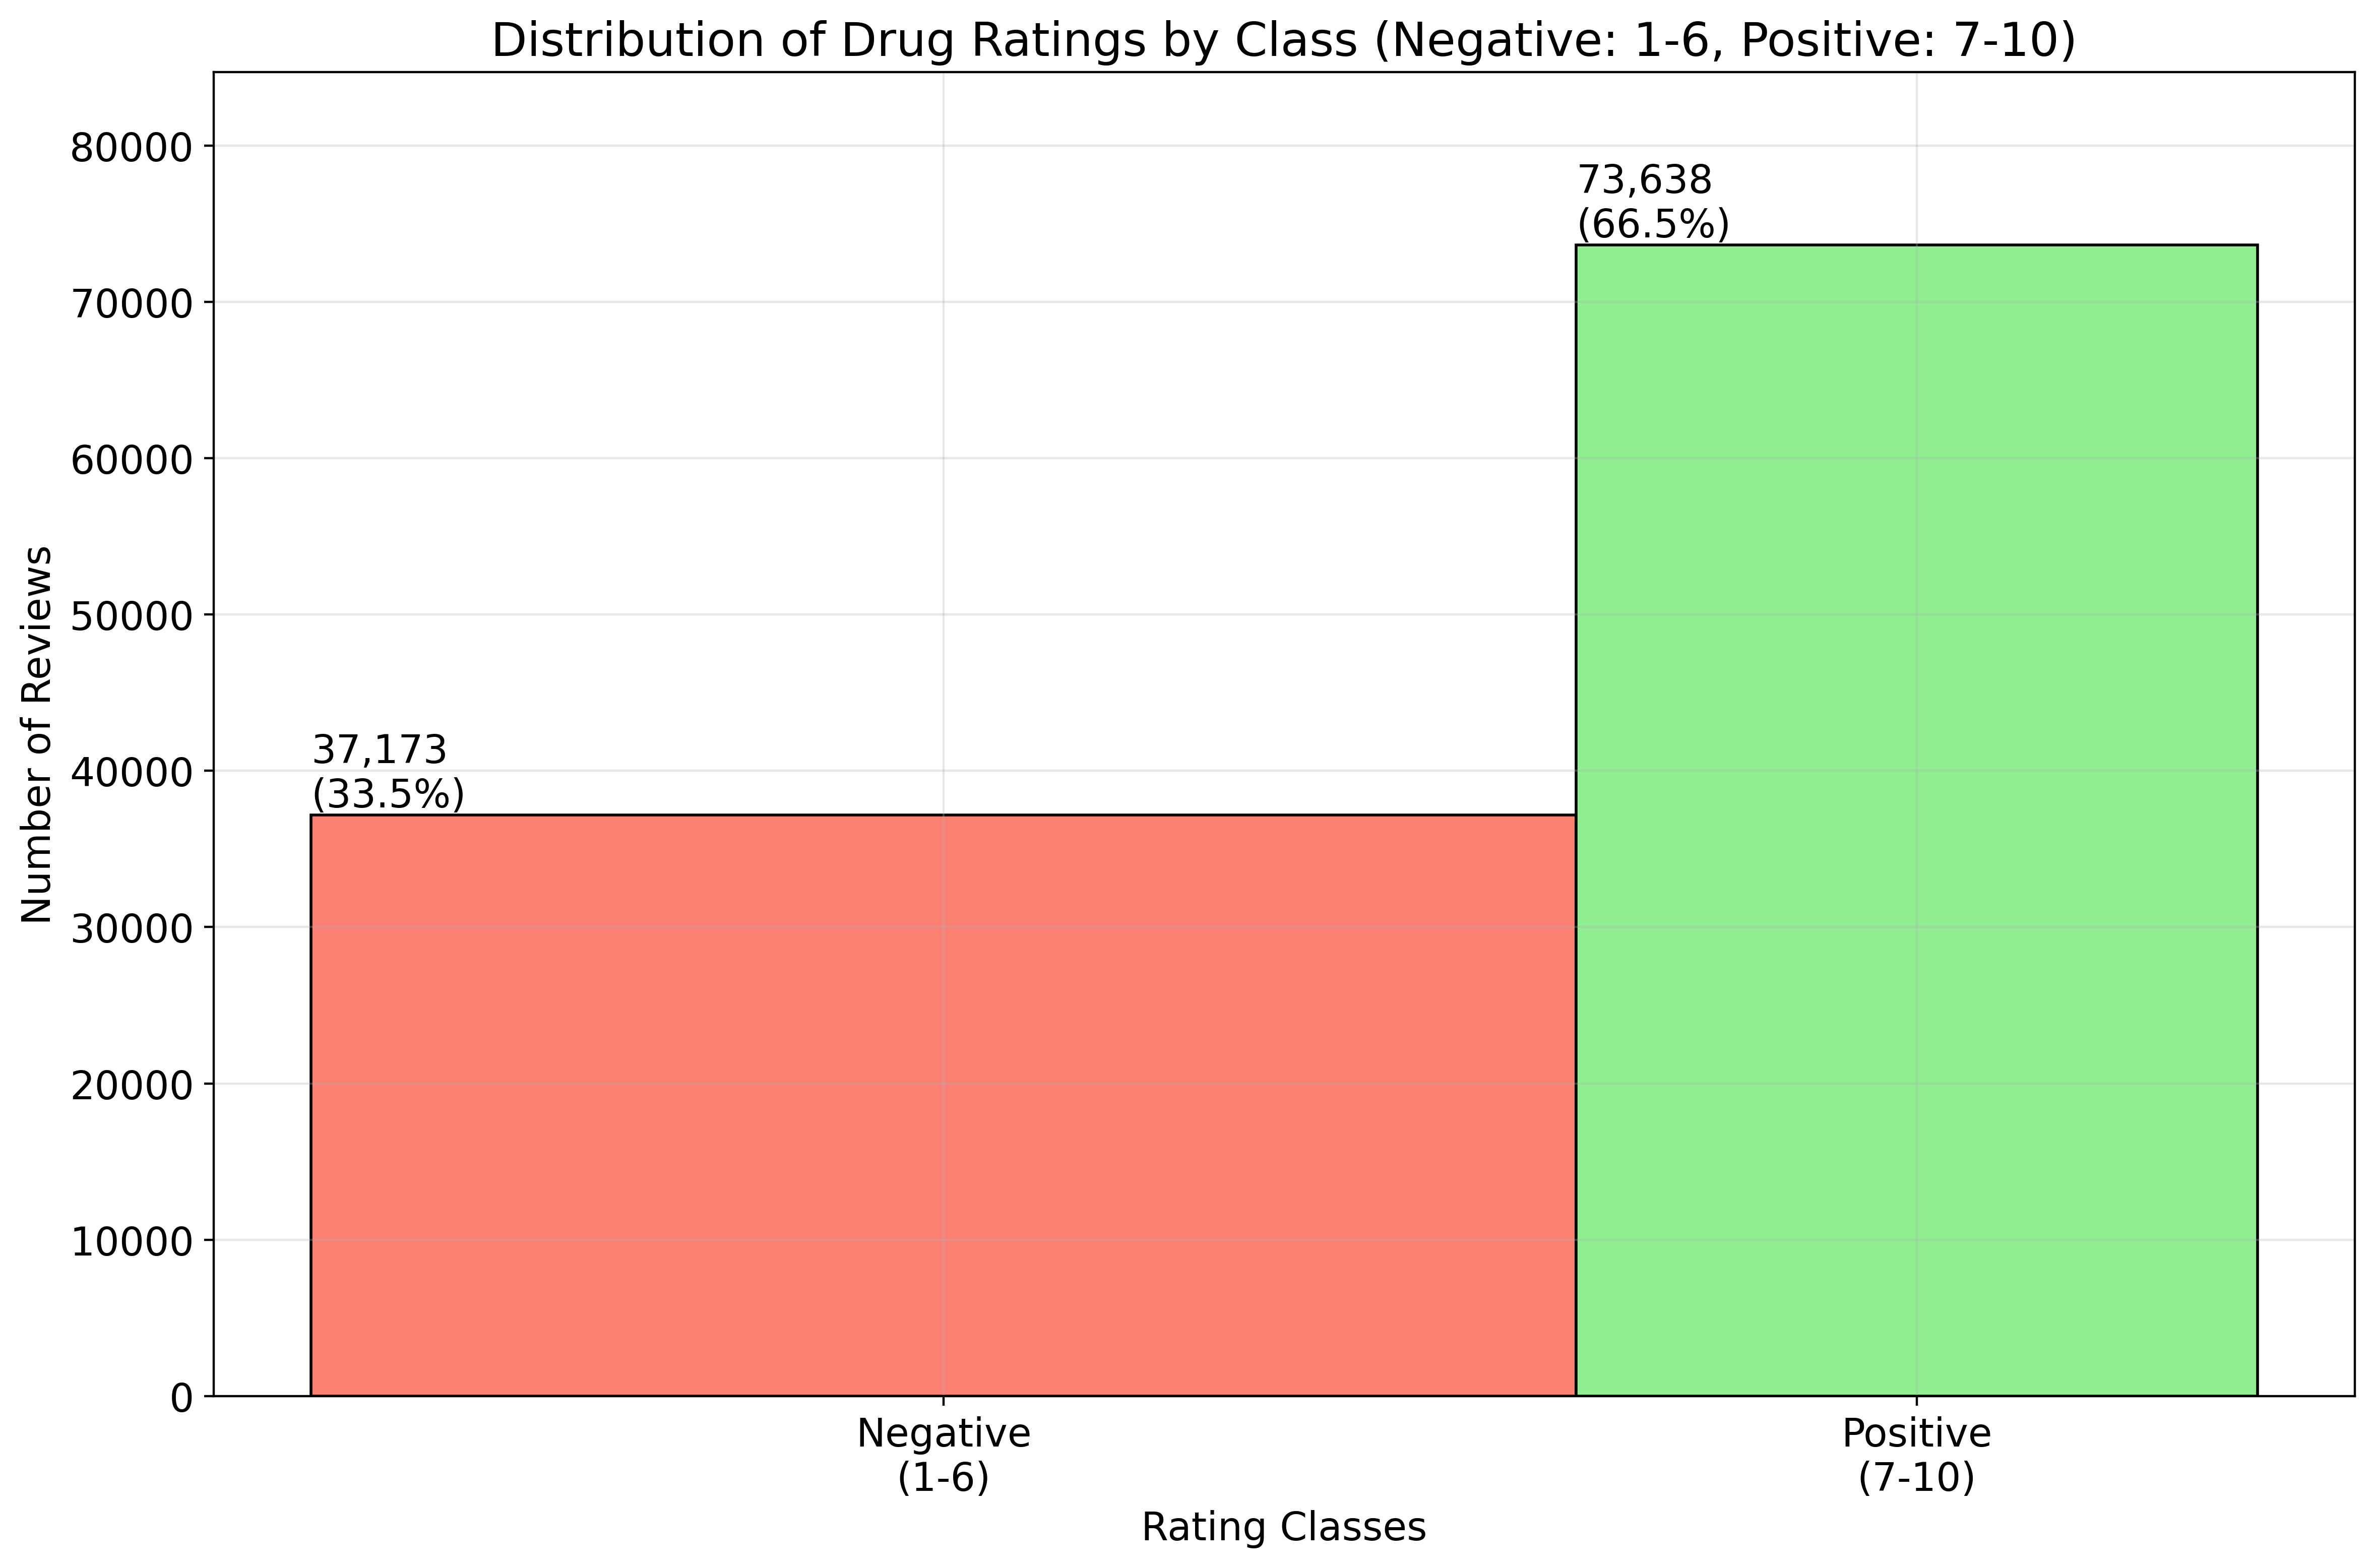


--- Class Distribution Statistics ---
Total reviews: 110,811
Negative class (1-6): 37,173 reviews (33.5%)
Positive class (7-10): 73,638 reviews (66.5%)


In [10]:
# Create histogram with two class distributions
plt.figure(figsize=(12, 8), dpi=400)

# Define the bins for negative (1-6) and positive (7-10) classes
bins = [0, 6.5, 10]  # Using 6.5 as the boundary to properly separate 6 and 7
counts, bins, patches = plt.hist(df['rating'], bins=bins, edgecolor='black')
total = len(df['rating'])

# Color the bars differently
patches[0].set_facecolor('salmon')  # Negative class (1-6)
patches[1].set_facecolor('lightgreen')  # Positive class (7-10)

# Calculate maximum y value needed
max_count = max(counts)
y_margin = max_count * 0.15  # Add 15% margin for labels

# Set y-axis limit
plt.ylim(0, max_count + y_margin)


# Add percentage labels on top of each bar
for i in range(len(counts)):
    percentage = (counts[i]/total) * 100
    plt.text(bins[i], counts[i], 
             f'{counts[i]:,.0f}\n({percentage:.1f}%)', 
             va='bottom')

plt.title('Distribution of Drug Ratings by Class (Negative: 1-6, Positive: 7-10)')
plt.xlabel('Rating Classes')
plt.ylabel('Number of Reviews')
plt.grid(True, alpha=0.3)

# Customize x-axis labels
plt.xticks([3.25, 8.25], ['Negative\n(1-6)', 'Positive\n(7-10)'])

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n--- Class Distribution Statistics ---")
print(f"Total reviews: {total:,}")
print(f"Negative class (1-6): {counts[0]:,.0f} reviews ({(counts[0]/total)*100:.1f}%)")
print(f"Positive class (7-10): {counts[1]:,.0f} reviews ({(counts[1]/total)*100:.1f}%)")


1. **Purpose**: This histogram shows how the drug reviews are distributed when split into two classes based on ratings:
   - Negative class: Ratings from 1-6
   - Positive class: Ratings from 7-10

2. **Visual Elements**:
   - Red (salmon) bar: Represents negative reviews (ratings 1-6)
   - Green bar: Represents positive reviews (ratings 7-10)
   - Each bar shows both the count and percentage of reviews

3. **Key Findings**:
   - Total Dataset Size: 110,811 reviews
   - Negative Reviews (1-6): 37,173 reviews (33.5%)
   - Positive Reviews (7-10): 73,638 reviews (66.5%)

4. **Interpretation**:
   - The data is imbalanced, with about twice as many positive reviews as negative ones
   - Roughly 2/3 of all reviews are positive (7-10 rating)
   - Only 1/3 of reviews are negative (1-6 rating)

5. **Implications**:
   - This imbalance suggests people are more likely to leave positive reviews
   - We might need to consider techniques to handle class imbalance (like oversampling, undersampling, or class weights)

## Data pre-processing

The dataset has been mentioned to be clean. Therefore, we just need to remove the row index. This has to be done during testing as well.

## Feature Engineering
   - Create text-based features from reviews (length, sentiment scores, etc.)
   - Handle date features (extract year, month, etc.)
   - Encode categorical variables (drugName, condition)

In [11]:
print("\n=== Starting Data Preprocessing ===")

# Remove Unnamed column if it exists
if "Unnamed: 0" in df.columns:
    df = df.drop("Unnamed: 0", axis=1)

# Create binary sentiment labels (0 for ratings 1-6, 1 for ratings 7-10)
print("\nCreating sentiment labels...")
df["sentiment_label"] = (df["rating"] >= 7).astype(int)

# For DistilBERT, we'll just use the raw review text
# No need for text preprocessing as the model's tokenizer will handle it

print("\n=== Basic Preprocessing Complete ===")
print(f"Total reviews: {len(df):,}")
print(f"Positive reviews (rating >= 7): {df['sentiment_label'].sum():,}")
print(f"Negative reviews (rating < 7): {len(df) - df['sentiment_label'].sum():,}")


=== Starting Data Preprocessing ===

Creating sentiment labels...

=== Basic Preprocessing Complete ===
Total reviews: 110,811
Positive reviews (rating >= 7): 73,638
Negative reviews (rating < 7): 37,173


## Data Splitting
   - Split data into training and validation sets
   - Consider temporal splits given the date column
   - Ensure balanced distribution of classes


In [12]:
# Convert date column to datetime
print("\n=== Preparing Data Split ===")
df["date"] = pd.to_datetime(df["date"])

# Sort by date
df = df.sort_values("date")

# Calculate split points (80% train, 10% val, 10% test)
train_end_idx = int(len(df) * 0.8)
val_end_idx = int(len(df) * 0.9)

# Split the data
train_df = df[:train_end_idx]
val_df = df[train_end_idx:val_end_idx]
test_df = df[val_end_idx:]

# Print split statistics
print("\n=== Data Split Statistics ===")
print(f"Training set: {len(train_df):,} reviews")
print( f"  Positive: {train_df['sentiment_label'].sum():,} ({train_df['sentiment_label'].mean()*100:.1f}%)")
print( f"  Negative: {len(train_df) - train_df['sentiment_label'].sum():,} ({(1-train_df['sentiment_label'].mean())*100:.1f}%)")
print( f"  Date range: {train_df['date'].min().strftime('%Y-%m-%d')} to {train_df['date'].max().strftime('%Y-%m-%d')}")

print(f"\nValidation set: {len(val_df):,} reviews")
print( f"  Positive: {val_df['sentiment_label'].sum():,} ({val_df['sentiment_label'].mean()*100:.1f}%)")
print( f"  Negative: {len(val_df) - val_df['sentiment_label'].sum():,} ({(1-val_df['sentiment_label'].mean())*100:.1f}%)")
print( f"  Date range: {val_df['date'].min().strftime('%Y-%m-%d')} to {val_df['date'].max().strftime('%Y-%m-%d')}")

print(f"\nTest set: {len(test_df):,} reviews")
print( f"  Positive: {test_df['sentiment_label'].sum():,} ({test_df['sentiment_label'].mean()*100:.1f}%)")
print( f"  Negative: {len(test_df) - test_df['sentiment_label'].sum():,} ({(1-test_df['sentiment_label'].mean())*100:.1f}%)")
print( f"  Date range: {test_df['date'].min().strftime('%Y-%m-%d')} to {test_df['date'].max().strftime('%Y-%m-%d')}")


=== Preparing Data Split ===

=== Data Split Statistics ===
Training set: 88,648 reviews
  Positive: 61,494 (69.4%)
  Negative: 27,154 (30.6%)
  Date range: 2008-02-24 to 2016-12-03

Validation set: 11,081 reviews
  Positive: 6,172 (55.7%)
  Negative: 4,909 (44.3%)
  Date range: 2016-12-03 to 2017-05-10

Test set: 11,082 reviews
  Positive: 5,972 (53.9%)
  Negative: 5,110 (46.1%)
  Date range: 2017-05-10 to 2017-12-12


## Model Development
### Direct Training approach
- Define target variable (likely rating)
- Build and train deep learning models
- Evaluate validation data

We'll train two models to compare: one trained from scratch, and another transfer learning.

In [13]:
# Can't fully reuse part 1 sadly.

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCH,
    model_name="Model",
    class_weights=None,
    early_stopping_patience=3,
    gradient_accumulation_steps=1,
):
    """
    Train a model for sentiment classification with advanced training features.

    Args:
        model: The neural network model
        dataloaders: Dictionary containing 'train' and 'valid' dataloaders
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        num_epochs: Number of training epochs
        model_name: Name for saving the model
        class_weights: Weights for handling class imbalance
        early_stopping_patience: Number of epochs to wait before early stopping
        gradient_accumulation_steps: Number of steps to accumulate gradients
    """
    # Initialize tracking variables
    best_val_f1 = 0.0
    patience_counter = 0
    train_metrics = {"loss": [], "acc": [], "f1": []}
    val_metrics = {"loss": [], "acc": [], "f1": []}

    # Move model and criterion to device
    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(num_epochs):
        logger.info(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        optimizer.zero_grad(set_to_none=True)

        train_pbar = tqdm(
            dataloaders["train"], desc="Training", position=1, leave=False
        )

        for batch_idx, batch in enumerate(train_pbar):
            # Move data to device
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss = loss / gradient_accumulation_steps  # Scale loss

            # Backward pass
            loss.backward()

            # Gradient accumulation
            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                # Clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)

            # Track metrics
            running_loss += loss.item() * gradient_accumulation_steps
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            train_pbar.set_postfix(
                {
                    "loss": f"{loss.item():.4f}",
                }
            )

        # Calculate epoch metrics
        epoch_loss = running_loss / len(dataloaders["train"])
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average="weighted")

        train_metrics["loss"].append(epoch_loss)
        train_metrics["acc"].append(epoch_acc)
        train_metrics["f1"].append(epoch_f1)

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            val_pbar = tqdm(
                dataloaders["valid"], desc="Validation", position=1, leave=False
            )

            for batch in val_pbar:
                input_ids = batch['input_ids'].to(device, non_blocking=True)
                attention_mask = batch['attention_mask'].to(device, non_blocking=True)
                labels = batch['labels'].to(device, non_blocking=True)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        # Calculate validation metrics
        val_loss = val_loss / len(dataloaders["valid"])
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, average="weighted")

        val_metrics["loss"].append(val_loss)
        val_metrics["acc"].append(val_acc)
        val_metrics["f1"].append(val_f1)

        # Log metrics
        logger.info(
            f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}"
        )
        logger.info(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Model checkpointing based on F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            logger.info("Saving best model checkpoint...")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "best_val_f1": best_val_f1,
                },
                f"best_{model_name}.pth",
            )
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= early_stopping_patience:
            logger.info(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Plot training history
    plot_training_history(train_metrics, val_metrics, model_name)

    return train_metrics, val_metrics


def plot_training_history(train_metrics, val_metrics, model_name):
    """Plot training and validation metrics history."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot loss
    axes[0].plot(train_metrics["loss"], label="Train")
    axes[0].plot(val_metrics["loss"], label="Val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    # Plot accuracy
    axes[1].plot(train_metrics["acc"], label="Train")
    axes[1].plot(val_metrics["acc"], label="Val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    # Plot F1 score
    axes[2].plot(train_metrics["f1"], label="Train")
    axes[2].plot(val_metrics["f1"], label="Val")
    axes[2].set_title("F1 Score")
    axes[2].set_xlabel("Epoch")
    axes[2].legend()

    plt.suptitle(f"Training History - {model_name}")
    plt.tight_layout()
    plt.show()

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes=2):
        super(SentimentClassifier, self).__init__()
        self.minilm = AutoModelForSequenceClassification.from_pretrained(
            "microsoft/MiniLM-L12-H384-uncased",
            num_labels=n_classes
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.minilm(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return outputs.logits

Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-02-23 00:40:30,664 - INFO - 
Epoch 1/20


Training:   0%|          | 0/5541 [00:00<?, ?it/s]

Validation:   0%|          | 0/693 [00:00<?, ?it/s]

2025-02-23 00:47:31,133 - INFO - Train Loss: 0.4584 Acc: 0.7880 F1: 0.7924
2025-02-23 00:47:31,133 - INFO - Val Loss: 0.4177 Acc: 0.8031 F1: 0.8035
2025-02-23 00:47:31,133 - INFO - Saving best model checkpoint...
2025-02-23 00:47:31,619 - INFO - 
Epoch 2/20


Training:   0%|          | 0/5541 [00:00<?, ?it/s]

Validation:   0%|          | 0/693 [00:00<?, ?it/s]

2025-02-23 00:54:33,656 - INFO - Train Loss: 0.3568 Acc: 0.8460 F1: 0.8490
2025-02-23 00:54:33,656 - INFO - Val Loss: 0.4136 Acc: 0.8150 F1: 0.8152
2025-02-23 00:54:33,656 - INFO - Saving best model checkpoint...
2025-02-23 00:54:34,150 - INFO - 
Epoch 3/20


Training:   0%|          | 0/5541 [00:00<?, ?it/s]

Validation:   0%|          | 0/693 [00:00<?, ?it/s]

2025-02-23 01:01:32,746 - INFO - Train Loss: 0.2977 Acc: 0.8770 F1: 0.8791
2025-02-23 01:01:32,746 - INFO - Val Loss: 0.4305 Acc: 0.8157 F1: 0.8157
2025-02-23 01:01:32,746 - INFO - Saving best model checkpoint...
2025-02-23 01:01:33,257 - INFO - 
Epoch 4/20


Training:   0%|          | 0/5541 [00:00<?, ?it/s]

Validation:   0%|          | 0/693 [00:00<?, ?it/s]

2025-02-23 01:08:34,441 - INFO - Train Loss: 0.2466 Acc: 0.9017 F1: 0.9031
2025-02-23 01:08:34,441 - INFO - Val Loss: 0.4955 Acc: 0.8164 F1: 0.8164
2025-02-23 01:08:34,442 - INFO - Saving best model checkpoint...
2025-02-23 01:08:35,050 - INFO - 
Epoch 5/20


Training:   0%|          | 0/5541 [00:00<?, ?it/s]

Validation:   0%|          | 0/693 [00:00<?, ?it/s]

2025-02-23 01:15:37,164 - INFO - Train Loss: 0.2046 Acc: 0.9221 F1: 0.9230
2025-02-23 01:15:37,165 - INFO - Val Loss: 0.5529 Acc: 0.8166 F1: 0.8165
2025-02-23 01:15:37,165 - INFO - Saving best model checkpoint...
2025-02-23 01:15:37,685 - INFO - 
Epoch 6/20


Training:   0%|          | 0/5541 [00:00<?, ?it/s]

Validation:   0%|          | 0/693 [00:00<?, ?it/s]

2025-02-23 01:22:37,883 - INFO - Train Loss: 0.1439 Acc: 0.9498 F1: 0.9502
2025-02-23 01:22:37,884 - INFO - Val Loss: 0.6788 Acc: 0.8175 F1: 0.8166
2025-02-23 01:22:37,884 - INFO - Saving best model checkpoint...
2025-02-23 01:22:38,426 - INFO - 
Epoch 7/20


Training:   0%|          | 0/5541 [00:00<?, ?it/s]

Validation:   0%|          | 0/693 [00:00<?, ?it/s]

2025-02-23 01:29:39,401 - INFO - Train Loss: 0.1321 Acc: 0.9545 F1: 0.9548
2025-02-23 01:29:39,402 - INFO - Val Loss: 0.6856 Acc: 0.8187 F1: 0.8178
2025-02-23 01:29:39,402 - INFO - Saving best model checkpoint...
2025-02-23 01:29:39,883 - INFO - 
Epoch 8/20


Training:   0%|          | 0/5541 [00:00<?, ?it/s]

Validation:   0%|          | 0/693 [00:00<?, ?it/s]

2025-02-23 01:36:37,558 - INFO - Train Loss: 0.1241 Acc: 0.9578 F1: 0.9581
2025-02-23 01:36:37,559 - INFO - Val Loss: 0.7082 Acc: 0.8183 F1: 0.8173
2025-02-23 01:36:37,559 - INFO - 
Epoch 9/20


Training:   0%|          | 0/5541 [00:00<?, ?it/s]

Validation:   0%|          | 0/693 [00:00<?, ?it/s]

2025-02-23 01:43:38,350 - INFO - Train Loss: 0.1166 Acc: 0.9602 F1: 0.9605
2025-02-23 01:43:38,350 - INFO - Val Loss: 0.7082 Acc: 0.8181 F1: 0.8172
2025-02-23 01:43:38,351 - INFO - 
Epoch 10/20


Training:   0%|          | 0/5541 [00:00<?, ?it/s]

Validation:   0%|          | 0/693 [00:00<?, ?it/s]

2025-02-23 01:50:38,683 - INFO - Train Loss: 0.1163 Acc: 0.9608 F1: 0.9610
2025-02-23 01:50:38,683 - INFO - Val Loss: 0.7207 Acc: 0.8178 F1: 0.8168
2025-02-23 01:50:38,684 - INFO - Early stopping triggered after 10 epochs


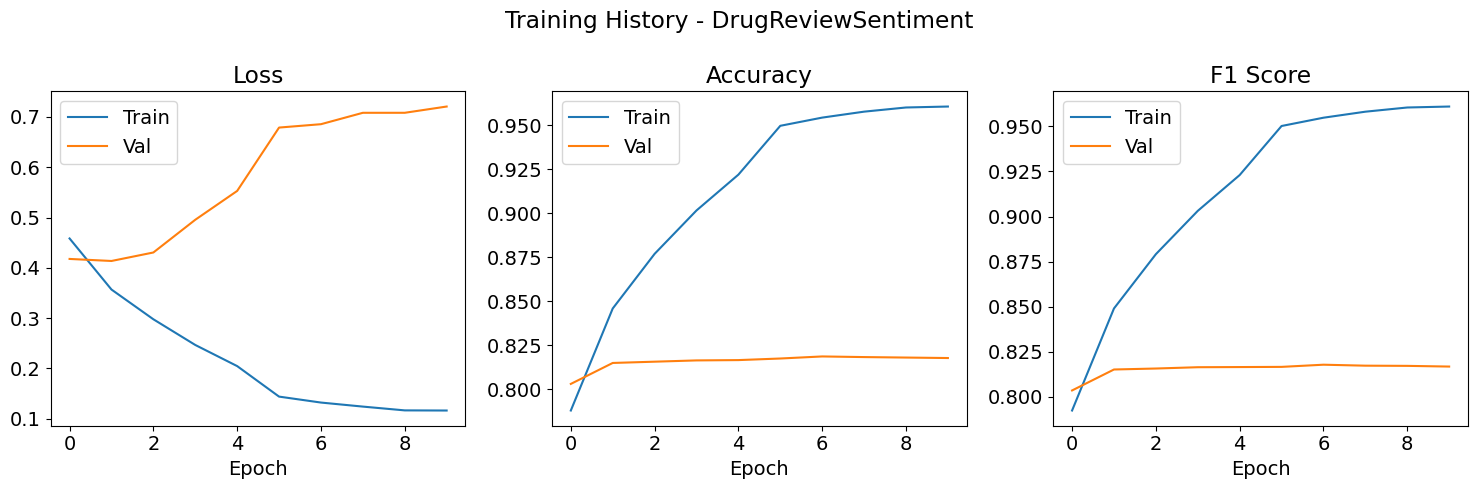

In [15]:
# Initialize training components
def initialize_training(train_df, val_df, batch_size=16, max_length=64):
    """
    Initialize all components needed for training
    Args:
        train_df (DataFrame): Training dataframe
        val_df (DataFrame): Validation dataframe
        batch_size (int): Batch size for training
        max_length (int): Maximum sequence length
    """
    # Set device
    print(f"Using device: {device}")

    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")

    # Create datasets
    train_dataset = DrugReviewDataset(
        train_df["review"].values,
        train_df["sentiment_label"].values,
        tokenizer,
        max_length,
    )

    val_dataset = DrugReviewDataset(
        val_df["review"].values, val_df["sentiment_label"].values, tokenizer, max_length
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    # Calculate class weights for imbalanced dataset
    total_samples = len(train_df)
    neg_samples = (train_df["sentiment_label"] == 0).sum()
    pos_samples = (train_df["sentiment_label"] == 1).sum()

    class_weights = torch.tensor(
        [total_samples / (2 * neg_samples), total_samples / (2 * pos_samples)],
        dtype=torch.float32,
    ).to(device)

    # Initialize model
    model = SentimentClassifier().to(device)

    # Initialize optimizer with weight decay
    optimizer = AdamW(
        model.parameters(), lr=2e-5, weight_decay=0.01
    )

    # Initialize scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=2
    )

    # Initialize loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    return {
        "device": device,
        "model": model,
        "train_loader": train_loader,
        "val_loader": val_loader,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "criterion": criterion,
        "class_weights": class_weights,
    }


training_components = initialize_training(train_df, val_df)

# Create dataloaders dictionary for the train_model function
dataloaders = {
    "train": training_components["train_loader"],
    "valid": training_components["val_loader"],
}

# Train the model
train_metrics, val_metrics = train_model(
    model=training_components["model"],
    dataloaders=dataloaders,
    criterion=training_components["criterion"],
    optimizer=training_components["optimizer"],
    scheduler=training_components["scheduler"],
    model_name="DrugReviewSentiment",
    class_weights=training_components["class_weights"],
    early_stopping_patience=3,
    gradient_accumulation_steps=4,
)

In [16]:
class SentimentClassifierFromScratch(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=256, n_layers=2, dropout=0.5):
        super(SentimentClassifierFromScratch, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim  # Save hidden_dim as instance variable

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 2)

        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        # Move tensors to the same device as the model
        device = input_ids.device
        batch_size = input_ids.size(0)

        # Get embeddings
        embedded = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]

        # Initialize hidden state and cell state
        h0 = torch.zeros(2 * 2, batch_size, self.hidden_dim).to(device)  # 2 for bidirectional
        c0 = torch.zeros(2 * 2, batch_size, self.hidden_dim).to(device)

        # Pass through LSTM with initial states
        lstm_out, (hidden, cell) = self.lstm(embedded, (h0, c0))

        # Get final hidden state
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        # Pass through fully connected layers
        dense1 = self.dropout(self.relu(self.fc1(hidden)))
        output = self.fc2(dense1)

        return output


In [17]:
# Vocabulary builder
def build_vocabulary(texts, min_freq=5):
    """
    Build vocabulary from texts
    
    Args:
        texts: List of text strings
        min_freq: Minimum frequency for a word to be included
    """
    word_freq = Counter()
    for text in texts:
        word_freq.update(text.split())
    
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    
    return vocab

# Training function
def train_from_scratch(model, train_loader, val_loader, criterion, optimizer, n_epochs=NUM_EPOCH, device='mps'):
    """
    Train the from-scratch model
    """
    best_val_loss = float('inf')
    model = model.to(device)  # Ensure model is on correct device
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}')
        for batch in train_pbar:
            # Ensure tensors are on correct device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            try:
                # Forward pass
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                
            except RuntimeError as e:
                print(f"Error during training: {e}")
                print(f"Input shapes - ids: {input_ids.shape}, mask: {attention_mask.shape}")
                raise e
        
        # Calculate training metrics
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        print(f'\nEpoch {epoch+1}:')
        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'vocab_size': len(vocab),
                'vocab': vocab  # Save the vocabulary
            }, 'best_scratch_model.pth')



# Build vocabulary
vocab = build_vocabulary(train_df['review'])

# Create datasets
train_dataset = TextDatasetFromScratch(
    train_df['review'].values,
    train_df['sentiment_label'].values,
    vocab
)

# Create model
model = SentimentClassifierFromScratch(
    vocab_size=len(vocab),
    embedding_dim=100,
    hidden_dim=256
)

# Train model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_from_scratch(model, training_components["train_loader"], training_components["val_loader"], criterion, optimizer)

Epoch 1/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 1:
Train Loss: 0.6178, Acc: 0.6934, F1: 0.5705
Val Loss: 0.7204, Acc: 0.5570, F1: 0.3985


Epoch 2/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 2:
Train Loss: 0.6137, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7295, Acc: 0.5570, F1: 0.3985


Epoch 3/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 3:
Train Loss: 0.6140, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7283, Acc: 0.5570, F1: 0.3985


Epoch 4/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 4:
Train Loss: 0.6157, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7214, Acc: 0.5570, F1: 0.3985


Epoch 5/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 5:
Train Loss: 0.6156, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7284, Acc: 0.5570, F1: 0.3985


Epoch 6/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 6:
Train Loss: 0.6161, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7282, Acc: 0.5570, F1: 0.3985


Epoch 7/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 7:
Train Loss: 0.6161, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7219, Acc: 0.5570, F1: 0.3985


Epoch 8/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 8:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7313, Acc: 0.5570, F1: 0.3985


Epoch 9/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 9:
Train Loss: 0.6161, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7284, Acc: 0.5570, F1: 0.3985


Epoch 10/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 10:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7318, Acc: 0.5570, F1: 0.3985


Epoch 11/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 11:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7321, Acc: 0.5570, F1: 0.3985


Epoch 12/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 12:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7312, Acc: 0.5570, F1: 0.3985


Epoch 13/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 13:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7269, Acc: 0.5570, F1: 0.3985


Epoch 14/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 14:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7247, Acc: 0.5570, F1: 0.3985


Epoch 15/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 15:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7270, Acc: 0.5570, F1: 0.3985


Epoch 16/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 16:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7281, Acc: 0.5570, F1: 0.3985


Epoch 17/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 17:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7278, Acc: 0.5570, F1: 0.3985


Epoch 18/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 18:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7256, Acc: 0.5570, F1: 0.3985


Epoch 19/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 19:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7235, Acc: 0.5570, F1: 0.3985


Epoch 20/20:   0%|          | 0/5541 [00:00<?, ?it/s]


Epoch 20:
Train Loss: 0.6162, Acc: 0.6937, F1: 0.5682
Val Loss: 0.7282, Acc: 0.5570, F1: 0.3985


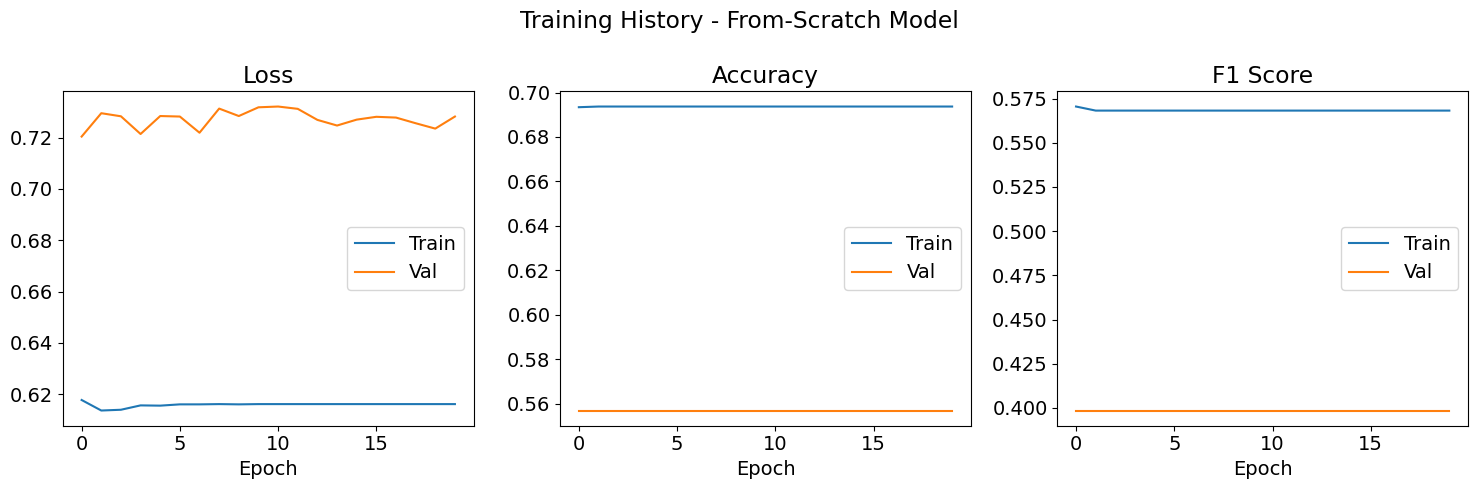

In [42]:
# forgot to display plot oops
epochs = range(1, 21)  # 20 epochs

# Create training metrics dictionary
train_metrics = {
    "loss": [0.6178, 0.6137, 0.6140, 0.6157, 0.6156, 0.6161, 0.6161, 0.6162, 0.6161, 0.6162,
             0.6162, 0.6162, 0.6162, 0.6162, 0.6162, 0.6162, 0.6162, 0.6162, 0.6162, 0.6162],
    "acc": [0.6934, 0.6937, 0.6937, 0.6937, 0.6937, 0.6937, 0.6937, 0.6937, 0.6937, 0.6937,
            0.6937, 0.6937, 0.6937, 0.6937, 0.6937, 0.6937, 0.6937, 0.6937, 0.6937, 0.6937],
    "f1": [0.5705, 0.5682, 0.5682, 0.5682, 0.5682, 0.5682, 0.5682, 0.5682, 0.5682, 0.5682,
           0.5682, 0.5682, 0.5682, 0.5682, 0.5682, 0.5682, 0.5682, 0.5682, 0.5682, 0.5682]
}

# Create validation metrics dictionary
val_metrics = {
    "loss": [0.7204, 0.7295, 0.7283, 0.7214, 0.7284, 0.7282, 0.7219, 0.7313, 0.7284, 0.7318,
             0.7321, 0.7312, 0.7269, 0.7247, 0.7270, 0.7281, 0.7278, 0.7256, 0.7235, 0.7282],
    "acc": [0.5570, 0.5570, 0.5570, 0.5570, 0.5570, 0.5570, 0.5570, 0.5570, 0.5570, 0.5570,
            0.5570, 0.5570, 0.5570, 0.5570, 0.5570, 0.5570, 0.5570, 0.5570, 0.5570, 0.5570],
    "f1": [0.3985, 0.3985, 0.3985, 0.3985, 0.3985, 0.3985, 0.3985, 0.3985, 0.3985, 0.3985,
           0.3985, 0.3985, 0.3985, 0.3985, 0.3985, 0.3985, 0.3985, 0.3985, 0.3985, 0.3985]
}

# Call the plotting function
plot_training_history(train_metrics, val_metrics, "From-Scratch Model")


### Indirect Training approach
- Define indirect signals/proxies
- Build and train models
- Compare with direct training resultss

let's use the popular sentiment classification dataset: IMDB movie reviews.

This is chosen because its well cleaned and well labelled.

In [18]:
def prepare_indirect_training(batch_size=16, max_length=64):
    """
    Prepare indirect training components using IMDB dataset
    """
    # Load IMDB dataset
    logging.info("Loading IMDB dataset...")
    imdb_dataset = load_dataset("imdb")
    
    # Initialize tokenizer (using the same model as direct training)
    tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
    
    # Prepare training data
    train_dataset = IndirectDataset(
        imdb_dataset["train"]["text"],
        imdb_dataset["train"]["label"],
        tokenizer,
        max_length
    )
    
    # Prepare validation data
    val_dataset = IndirectDataset(
        imdb_dataset["test"]["text"],  # Using IMDB test set as validation
        imdb_dataset["test"]["label"],
        tokenizer,
        max_length
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
    
    return {
        "train_loader": train_loader,
        "val_loader": val_loader,
        "tokenizer": tokenizer
    }

def train_indirect_model(
    model,
    train_loader,
    val_loader,
    num_epochs=NUM_EPOCH,
    learning_rate=2e-5,
    device='mps'
):
    """
    Train model on indirect data (IMDB)
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    best_val_f1 = 0
    train_metrics = {"loss": [], "acc": [], "f1": []}
    val_metrics = {"loss": [], "acc": [], "f1": []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in train_pbar:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Calculate training metrics
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        train_metrics["loss"].append(epoch_loss)
        train_metrics["acc"].append(epoch_acc)
        train_metrics["f1"].append(epoch_f1)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        val_metrics["loss"].append(val_loss)
        val_metrics["acc"].append(val_acc)
        val_metrics["f1"].append(val_f1)
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_indirect_model.pth')
        
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        logging.info(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}")
        logging.info(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    
    return model, train_metrics, val_metrics

def evaluate_on_drug_reviews(model, test_loader, device='mps'):
    """
    Evaluate direct or indirect-trained model on drug review test set
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing on drug reviews"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    results = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, average='weighted'),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted')
    }
    
    return results

In [19]:
# Prepare indirect training components
indirect_components = prepare_indirect_training()

# Initialize model
model = SentimentClassifier()  # Your model class

# Train on indirect data (IMDB)
model, train_metrics, val_metrics = train_indirect_model(
    model,
    indirect_components["train_loader"],
    indirect_components["val_loader"]
)


2025-02-23 02:40:10,042 - INFO - Loading IMDB dataset...
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 02:44:46,887 - INFO - Epoch 1/20
2025-02-23 02:44:46,889 - INFO - Train Loss: 0.4472, Acc: 0.7826, F1: 0.7826
2025-02-23 02:44:46,890 - INFO - Val Loss: 0.3760, Acc: 0.8236, F1: 0.8236


Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 02:48:40,362 - INFO - Epoch 2/20
2025-02-23 02:48:40,363 - INFO - Train Loss: 0.3397, Acc: 0.8474, F1: 0.8474
2025-02-23 02:48:40,364 - INFO - Val Loss: 0.3976, Acc: 0.8288, F1: 0.8287


Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 02:52:31,381 - INFO - Epoch 3/20
2025-02-23 02:52:31,383 - INFO - Train Loss: 0.2667, Acc: 0.8855, F1: 0.8855
2025-02-23 02:52:31,383 - INFO - Val Loss: 0.3735, Acc: 0.8315, F1: 0.8313


Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 02:56:21,921 - INFO - Epoch 4/20
2025-02-23 02:56:21,922 - INFO - Train Loss: 0.1906, Acc: 0.9229, F1: 0.9229
2025-02-23 02:56:21,922 - INFO - Val Loss: 0.4688, Acc: 0.8329, F1: 0.8329


Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:00:12,380 - INFO - Epoch 5/20
2025-02-23 03:00:12,381 - INFO - Train Loss: 0.1345, Acc: 0.9494, F1: 0.9494
2025-02-23 03:00:12,381 - INFO - Val Loss: 0.5341, Acc: 0.8294, F1: 0.8291


Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:04:03,014 - INFO - Epoch 6/20
2025-02-23 03:04:03,015 - INFO - Train Loss: 0.0977, Acc: 0.9656, F1: 0.9656
2025-02-23 03:04:03,015 - INFO - Val Loss: 0.6150, Acc: 0.8284, F1: 0.8284


Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:07:53,019 - INFO - Epoch 7/20
2025-02-23 03:07:53,020 - INFO - Train Loss: 0.0765, Acc: 0.9736, F1: 0.9736
2025-02-23 03:07:53,021 - INFO - Val Loss: 0.6350, Acc: 0.8278, F1: 0.8275


Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:11:43,970 - INFO - Epoch 8/20
2025-02-23 03:11:43,971 - INFO - Train Loss: 0.0602, Acc: 0.9800, F1: 0.9800
2025-02-23 03:11:43,971 - INFO - Val Loss: 0.6951, Acc: 0.8214, F1: 0.8209


Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:15:34,983 - INFO - Epoch 9/20
2025-02-23 03:15:34,984 - INFO - Train Loss: 0.0506, Acc: 0.9835, F1: 0.9835
2025-02-23 03:15:34,984 - INFO - Val Loss: 0.7424, Acc: 0.8306, F1: 0.8306


Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:19:24,867 - INFO - Epoch 10/20
2025-02-23 03:19:24,868 - INFO - Train Loss: 0.0512, Acc: 0.9835, F1: 0.9835
2025-02-23 03:19:24,869 - INFO - Val Loss: 0.6625, Acc: 0.8284, F1: 0.8284


Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:23:15,299 - INFO - Epoch 11/20
2025-02-23 03:23:15,301 - INFO - Train Loss: 0.0397, Acc: 0.9879, F1: 0.9879
2025-02-23 03:23:15,301 - INFO - Val Loss: 0.7332, Acc: 0.8316, F1: 0.8315


Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:27:05,921 - INFO - Epoch 12/20
2025-02-23 03:27:05,922 - INFO - Train Loss: 0.0346, Acc: 0.9902, F1: 0.9902
2025-02-23 03:27:05,923 - INFO - Val Loss: 0.7566, Acc: 0.8307, F1: 0.8307


Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:30:57,461 - INFO - Epoch 13/20
2025-02-23 03:30:57,462 - INFO - Train Loss: 0.0338, Acc: 0.9894, F1: 0.9894
2025-02-23 03:30:57,463 - INFO - Val Loss: 0.8290, Acc: 0.8254, F1: 0.8250


Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:34:49,272 - INFO - Epoch 14/20
2025-02-23 03:34:49,273 - INFO - Train Loss: 0.0354, Acc: 0.9886, F1: 0.9886
2025-02-23 03:34:49,274 - INFO - Val Loss: 0.8640, Acc: 0.8276, F1: 0.8271


Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:38:41,058 - INFO - Epoch 15/20
2025-02-23 03:38:41,059 - INFO - Train Loss: 0.0296, Acc: 0.9907, F1: 0.9907
2025-02-23 03:38:41,059 - INFO - Val Loss: 0.7531, Acc: 0.8266, F1: 0.8264


Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:42:33,236 - INFO - Epoch 16/20
2025-02-23 03:42:33,237 - INFO - Train Loss: 0.0289, Acc: 0.9905, F1: 0.9905
2025-02-23 03:42:33,237 - INFO - Val Loss: 0.7998, Acc: 0.8270, F1: 0.8269


Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:46:23,353 - INFO - Epoch 17/20
2025-02-23 03:46:23,354 - INFO - Train Loss: 0.0255, Acc: 0.9918, F1: 0.9918
2025-02-23 03:46:23,355 - INFO - Val Loss: 0.8318, Acc: 0.8289, F1: 0.8289


Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:50:15,281 - INFO - Epoch 18/20
2025-02-23 03:50:15,282 - INFO - Train Loss: 0.0230, Acc: 0.9930, F1: 0.9930
2025-02-23 03:50:15,282 - INFO - Val Loss: 0.7675, Acc: 0.8274, F1: 0.8273


Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:54:03,948 - INFO - Epoch 19/20
2025-02-23 03:54:03,949 - INFO - Train Loss: 0.0238, Acc: 0.9924, F1: 0.9924
2025-02-23 03:54:03,949 - INFO - Val Loss: 0.7830, Acc: 0.8237, F1: 0.8236


Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-02-23 03:57:53,906 - INFO - Epoch 20/20
2025-02-23 03:57:53,908 - INFO - Train Loss: 0.0217, Acc: 0.9936, F1: 0.9936
2025-02-23 03:57:53,908 - INFO - Val Loss: 0.7536, Acc: 0.8286, F1: 0.8286


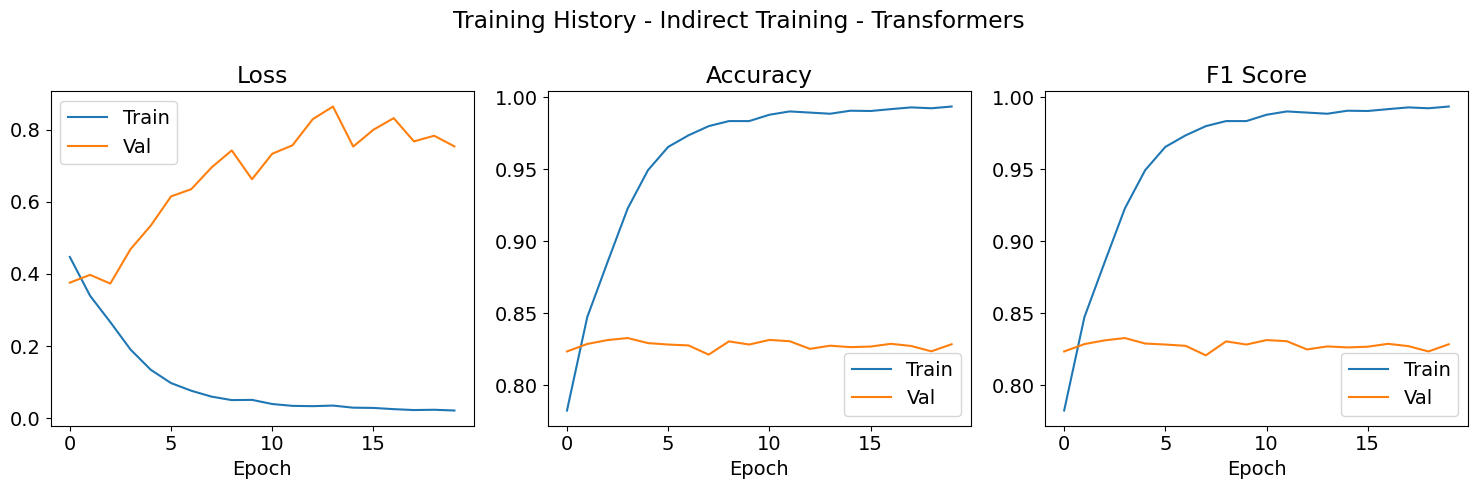

In [48]:


# Create training metrics dictionary
train_metrics = {
    "loss": [0.4472, 0.3397, 0.2667, 0.1906, 0.1345, 0.0977, 0.0765, 0.0602, 0.0506, 0.0512,
             0.0397, 0.0346, 0.0338, 0.0354, 0.0296, 0.0289, 0.0255, 0.0230, 0.0238, 0.0217],
    "acc": [0.7826, 0.8474, 0.8855, 0.9229, 0.9494, 0.9656, 0.9736, 0.9800, 0.9835, 0.9835,
            0.9879, 0.9902, 0.9894, 0.9886, 0.9907, 0.9905, 0.9918, 0.9930, 0.9924, 0.9936],
    "f1": [0.7826, 0.8474, 0.8855, 0.9229, 0.9494, 0.9656, 0.9736, 0.9800, 0.9835, 0.9835,
           0.9879, 0.9902, 0.9894, 0.9886, 0.9907, 0.9905, 0.9918, 0.9930, 0.9924, 0.9936]
}

# Create validation metrics dictionary
val_metrics = {
    "loss": [0.3760, 0.3976, 0.3735, 0.4688, 0.5341, 0.6150, 0.6350, 0.6951, 0.7424, 0.6625,
             0.7332, 0.7566, 0.8290, 0.8640, 0.7531, 0.7998, 0.8318, 0.7675, 0.7830, 0.7536],
    "acc": [0.8236, 0.8288, 0.8315, 0.8329, 0.8294, 0.8284, 0.8278, 0.8214, 0.8306, 0.8284,
            0.8316, 0.8307, 0.8254, 0.8276, 0.8266, 0.8270, 0.8289, 0.8274, 0.8237, 0.8286],
    "f1": [0.8236, 0.8287, 0.8313, 0.8329, 0.8291, 0.8284, 0.8275, 0.8209, 0.8306, 0.8284,
           0.8315, 0.8307, 0.8250, 0.8271, 0.8264, 0.8269, 0.8289, 0.8273, 0.8236, 0.8286]
}

# Call the plotting function
plot_training_history(train_metrics, val_metrics, "Indirect Training - Transformers")

In [20]:
# Create test dataset using DrugReviewDataset
test_dataset = DrugReviewDataset(
    reviews=test_df["review"].values,  # Using 'review' column
    labels=test_df["sentiment_label"].values,  # Using 'sentiment_label' column
    tokenizer=indirect_components["tokenizer"],
    max_length=MAX_LENGTH
)

# Create test dataloader
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Evaluate on drug review test set
test_results = evaluate_on_drug_reviews(model, test_loader)

Testing on drug reviews:   0%|          | 0/693 [00:00<?, ?it/s]

In [21]:
# Print results
print("\nTest Results on Drug Reviews:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")


Test Results on Drug Reviews:
accuracy: 0.707634001082837
f1: 0.705306967257346
precision: 0.7300488290346355
recall: 0.707634001082837


Preparing training components...
Loading IMDB dataset...
Vocabulary size: 49347

Starting training...


Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 1:
Train Loss: 0.6919, Acc: 0.5240, F1: 0.5224
Val Loss: 0.6932, Acc: 0.5004, F1: 0.3362


Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 2:
Train Loss: 0.6049, Acc: 0.6591, F1: 0.6590
Val Loss: 0.4433, Acc: 0.7924, F1: 0.7922


Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 3:
Train Loss: 0.3335, Acc: 0.8630, F1: 0.8630
Val Loss: 0.3685, Acc: 0.8362, F1: 0.8358


Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 4:
Train Loss: 0.1946, Acc: 0.9272, F1: 0.9272
Val Loss: 0.4038, Acc: 0.8347, F1: 0.8343


Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 5:
Train Loss: 0.1025, Acc: 0.9673, F1: 0.9673
Val Loss: 0.5015, Acc: 0.8455, F1: 0.8454


Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 6:
Train Loss: 0.0524, Acc: 0.9845, F1: 0.9845
Val Loss: 0.6075, Acc: 0.8310, F1: 0.8306


Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 7:
Train Loss: 0.0264, Acc: 0.9925, F1: 0.9925
Val Loss: 0.8652, Acc: 0.8351, F1: 0.8348


Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 8:
Train Loss: 0.0225, Acc: 0.9934, F1: 0.9934
Val Loss: 1.0397, Acc: 0.8362, F1: 0.8360


Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 9:
Train Loss: 0.0147, Acc: 0.9954, F1: 0.9954
Val Loss: 1.1362, Acc: 0.8374, F1: 0.8374


Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 10:
Train Loss: 0.0117, Acc: 0.9971, F1: 0.9971
Val Loss: 1.2712, Acc: 0.8358, F1: 0.8358


Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 11:
Train Loss: 0.0112, Acc: 0.9969, F1: 0.9969
Val Loss: 1.1998, Acc: 0.8373, F1: 0.8373


Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 12:
Train Loss: 0.0099, Acc: 0.9975, F1: 0.9975
Val Loss: 1.3750, Acc: 0.8353, F1: 0.8353


Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 13:
Train Loss: 0.0044, Acc: 0.9988, F1: 0.9988
Val Loss: 1.4307, Acc: 0.8320, F1: 0.8315


Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 14:
Train Loss: 0.0086, Acc: 0.9977, F1: 0.9977
Val Loss: 1.7426, Acc: 0.8344, F1: 0.8343


Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 15:
Train Loss: 0.0052, Acc: 0.9988, F1: 0.9988
Val Loss: 1.4422, Acc: 0.8299, F1: 0.8297


Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 16:
Train Loss: 0.0064, Acc: 0.9982, F1: 0.9982
Val Loss: 1.5500, Acc: 0.8326, F1: 0.8326


Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 17:
Train Loss: 0.0069, Acc: 0.9982, F1: 0.9982
Val Loss: 1.5939, Acc: 0.8335, F1: 0.8332


Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 18:
Train Loss: 0.0036, Acc: 0.9991, F1: 0.9991
Val Loss: 2.1447, Acc: 0.8347, F1: 0.8346


Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 19:
Train Loss: 0.0005, Acc: 0.9998, F1: 0.9998
Val Loss: 3.3284, Acc: 0.8175, F1: 0.8157


Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 20:
Train Loss: 0.0066, Acc: 0.9986, F1: 0.9986
Val Loss: 1.4806, Acc: 0.8290, F1: 0.8288


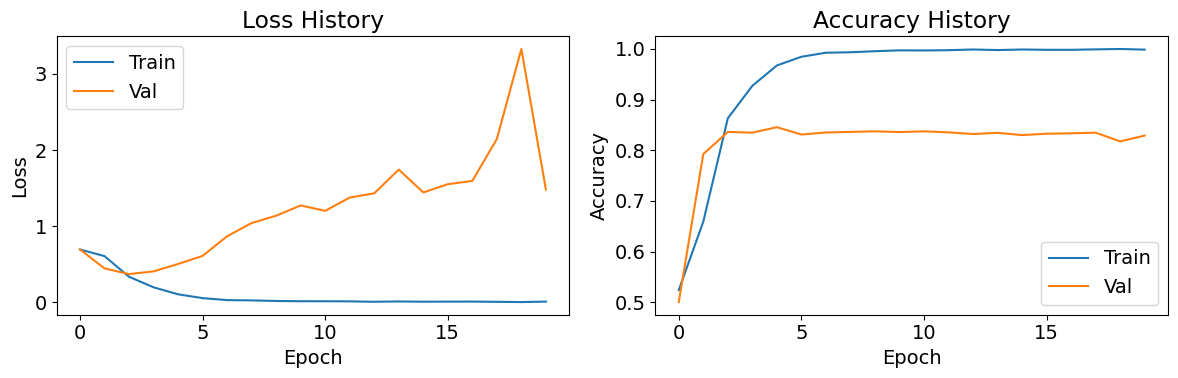

In [31]:
def prepare_indirect_scratch_training(batch_size=16, max_length=MAX_LENGTH):
    """
    Prepare indirect training components using IMDB dataset
    """
    # Load IMDB dataset
    print("Loading IMDB dataset...")
    imdb_dataset = load_dataset("imdb")
    
    # Initialize tokenizer for vocabulary building
    tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
    
    # Build vocabulary from IMDB training data
    vocab = build_vocabulary([text for text in imdb_dataset["train"]["text"]], min_freq=5)
    print(f"Vocabulary size: {len(vocab)}")
    
    # Create datasets
    train_dataset = TextDatasetFromScratch(
        texts=imdb_dataset["train"]["text"],
        labels=imdb_dataset["train"]["label"],
        vocab=vocab,
        max_length=max_length
    )
    
    val_dataset = TextDatasetFromScratch(
        texts=imdb_dataset["test"]["text"],
        labels=imdb_dataset["test"]["label"],
        vocab=vocab,
        max_length=max_length
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
    
    return {
        "train_loader": train_loader,
        "val_loader": val_loader,
        "vocab": vocab
    }

def train_indirect_scratch(model, train_loader, val_loader, criterion, optimizer, n_epochs=NUM_EPOCH, device='mps'):
    """
    Train the from-scratch model on indirect data (IMDB)
    """
    best_val_loss = float('inf')
    model = model.to(device)
    
    train_metrics = {"loss": [], "acc": [], "f1": []}
    val_metrics = {"loss": [], "acc": [], "f1": []}
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}')
        for batch in train_pbar:
            # Get batch data
            input_ids = batch['text'].to(device)  # Note: using 'text' instead of 'input_ids'
            lengths = batch['length'].to(device)
            labels = batch['label'].to(device)  # Note: using 'label' instead of 'labels'
            
            optimizer.zero_grad()
            
            try:
                # Forward pass
                outputs = model(input_ids, lengths)
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                
            except RuntimeError as e:
                print(f"Error during training: {e}")
                print(f"Input shapes - ids: {input_ids.shape}, lengths: {lengths.shape}")
                raise e
        
        # Calculate training metrics
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        train_metrics["loss"].append(epoch_loss)
        train_metrics["acc"].append(epoch_acc)
        train_metrics["f1"].append(epoch_f1)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['text'].to(device)
                lengths = batch['length'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(input_ids, lengths)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        val_metrics["loss"].append(val_loss)
        val_metrics["acc"].append(val_acc)
        val_metrics["f1"].append(val_f1)
        
        print(f'\nEpoch {epoch+1}:')
        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, 'best_scratch_indirect_model.pth')
    
    return model, train_metrics, val_metrics

def run_indirect_scratch_experiment():
    """
    Run complete indirect training experiment with from-scratch model
    """
    # Prepare indirect training components
    print("Preparing training components...")
    components = prepare_indirect_scratch_training()
    
    # Initialize model and training components
    model = SentimentClassifierFromScratch(
        vocab_size=len(components["vocab"]),
        embedding_dim=100,
        hidden_dim=256
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train model
    print("\nStarting training...")
    model, train_metrics, val_metrics = train_indirect_scratch(
        model=model,
        train_loader=components["train_loader"],
        val_loader=components["val_loader"],
        criterion=criterion,
        optimizer=optimizer
    )
    
    return model, components["vocab"], train_metrics, val_metrics

# Run the experiment
model, vocab, train_metrics, val_metrics = run_indirect_scratch_experiment()

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_metrics['loss'], label='Train')
plt.plot(val_metrics['loss'], label='Val')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_metrics['acc'], label='Train')
plt.plot(val_metrics['acc'], label='Val')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

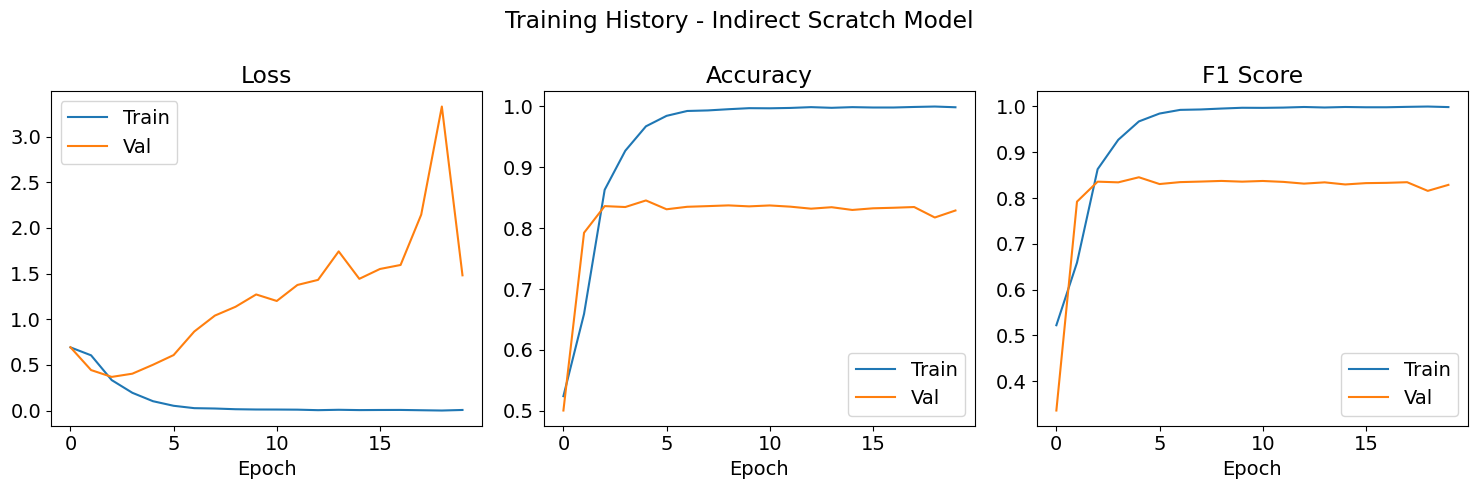

In [49]:
epochs = range(1, 21)  # 20 epochs

# Create training metrics dictionary
train_metrics = {
    "loss": [0.6919, 0.6049, 0.3335, 0.1946, 0.1025, 0.0524, 0.0264, 0.0225, 0.0147, 0.0117,
             0.0112, 0.0099, 0.0044, 0.0086, 0.0052, 0.0064, 0.0069, 0.0036, 0.0005, 0.0066],
    "acc":  [0.5240, 0.6591, 0.8630, 0.9272, 0.9673, 0.9845, 0.9925, 0.9934, 0.9954, 0.9971,
             0.9969, 0.9975, 0.9988, 0.9977, 0.9988, 0.9982, 0.9982, 0.9991, 0.9998, 0.9986],
    "f1":   [0.5224, 0.6590, 0.8630, 0.9272, 0.9673, 0.9845, 0.9925, 0.9934, 0.9954, 0.9971,
             0.9969, 0.9975, 0.9988, 0.9977, 0.9988, 0.9982, 0.9982, 0.9991, 0.9998, 0.9986]
}

# Create validation metrics dictionary
val_metrics = {
    "loss": [0.6932, 0.4433, 0.3685, 0.4038, 0.5015, 0.6075, 0.8652, 1.0397, 1.1362, 1.2712,
             1.1998, 1.3750, 1.4307, 1.7426, 1.4422, 1.5500, 1.5939, 2.1447, 3.3284, 1.4806],
    "acc":  [0.5004, 0.7924, 0.8362, 0.8347, 0.8455, 0.8310, 0.8351, 0.8362, 0.8374, 0.8358,
             0.8373, 0.8353, 0.8320, 0.8344, 0.8299, 0.8326, 0.8335, 0.8347, 0.8175, 0.8290],
    "f1":   [0.3362, 0.7922, 0.8358, 0.8343, 0.8454, 0.8306, 0.8348, 0.8360, 0.8374, 0.8358,
             0.8373, 0.8353, 0.8315, 0.8343, 0.8297, 0.8326, 0.8332, 0.8346, 0.8157, 0.8288]
}

# Call the plotting function
plot_training_history(train_metrics, val_metrics, "Indirect Scratch Model")

## Model Comparison
   - Compare direct vs indirect training approaches
   - Analyze pros and cons of each method
   - Discuss real-world applicability

In [38]:
# Load the saved model and print its structure
checkpoint = torch.load('best_DrugReviewSentiment.pth')

# Print model state dict structure
print("Model state dict keys:")
for key, value in checkpoint['model_state_dict'].items():
    print(f"{key}: Shape {value.shape}")

# Print optimizer state
print("\nOptimizer state dict keys:", checkpoint['optimizer_state_dict'].keys())

# Print other metadata
print("\nMetadata:")
print(f"Epoch: {checkpoint['epoch']}")
print(f"Best Val F1: {checkpoint['best_val_f1']}")

# For the DrugReviewDataset issue, let's try recreating the test loader:
test_dataset = DrugReviewDataset(
    reviews=test_df["review"].values,
    labels=test_df["sentiment_label"].values,
    tokenizer=AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased"),
    max_length=MAX_LENGTH
)

# Create a new test loader with num_workers=0 to avoid pickling issues
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid pickling issues
    pin_memory=True
)


Model state dict keys:
minilm.bert.embeddings.word_embeddings.weight: Shape torch.Size([30522, 384])
minilm.bert.embeddings.position_embeddings.weight: Shape torch.Size([512, 384])
minilm.bert.embeddings.token_type_embeddings.weight: Shape torch.Size([2, 384])
minilm.bert.embeddings.LayerNorm.weight: Shape torch.Size([384])
minilm.bert.embeddings.LayerNorm.bias: Shape torch.Size([384])
minilm.bert.encoder.layer.0.attention.self.query.weight: Shape torch.Size([384, 384])
minilm.bert.encoder.layer.0.attention.self.query.bias: Shape torch.Size([384])
minilm.bert.encoder.layer.0.attention.self.key.weight: Shape torch.Size([384, 384])
minilm.bert.encoder.layer.0.attention.self.key.bias: Shape torch.Size([384])
minilm.bert.encoder.layer.0.attention.self.value.weight: Shape torch.Size([384, 384])
minilm.bert.encoder.layer.0.attention.self.value.bias: Shape torch.Size([384])
minilm.bert.encoder.layer.0.attention.output.dense.weight: Shape torch.Size([384, 384])
minilm.bert.encoder.layer.0.atte

In [40]:
direct_scratch_checkpoint = torch.load('best_scratch_model.pth')
saved_vocab_size = direct_scratch_checkpoint['model_state_dict']['embedding.weight'].shape[0]
print(f"Saved vocabulary size: {saved_vocab_size}")  # Should be 30908

Saved vocabulary size: 30908


In [41]:
def compare_all_models(test_loader, vocab_size, device='mps'):
    """
    Compare all trained models on the drug review test set
    """
    # Load all models
    models = {
        'Direct Transformer': {
            'model': SentimentClassifier(),
            'path': 'best_DrugReviewSentiment.pth',
            'state_dict_key': 'model_state_dict'  # Uses nested state dict
        },
        'Indirect Transformer': {
            'model': SentimentClassifier(),
            'path': 'best_indirect_model.pth',
            'state_dict_key': None  # Direct state dict
        },
        'Direct Scratch': {
            'model': SentimentClassifierFromScratch(vocab_size=saved_vocab_size), 
            'path': 'best_scratch_model.pth',
            'state_dict_key': 'model_state_dict'
        },
        'Indirect Scratch': {
            'model': SentimentClassifierFromScratch(vocab_size=vocab_size),
            'path': 'best_scratch_indirect_model.pth',
            'state_dict_key': 'model_state_dict'
        }
    }
    
    results = {}
    
    # Evaluate each model
    for name, model_info in models.items():
        print(f"\nEvaluating {name}...")
        
        try:
            # Load model state
            checkpoint = torch.load(model_info['path'])
            
            # Handle different saving formats
            if model_info['state_dict_key'] is not None:
                # Nested state dict
                state_dict = checkpoint[model_info['state_dict_key']]
            else:
                # Direct state dict
                state_dict = checkpoint
            
            # Load state dict
            try:
                model_info['model'].load_state_dict(state_dict)
            except RuntimeError as e:
                print(f"Error loading state dict for {name}: {e}")
                print(f"Model vocab size: {vocab_size}")
                print(f"Checkpoint embedding size: {next(iter(state_dict.values())).shape}")
                continue
            
            # Move to device and evaluate
            model_info['model'].to(device)
            model_info['model'].eval()
            
            # Get predictions
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                for batch in tqdm(test_loader, desc=f"Testing {name}"):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    outputs = model_info['model'](input_ids, attention_mask)
                    preds = torch.argmax(outputs, dim=1)
                    
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            # Calculate metrics
            results[name] = {
                'accuracy': accuracy_score(all_labels, all_preds),
                'f1': f1_score(all_labels, all_preds, average='weighted'),
                'precision': precision_score(all_labels, all_preds, average='weighted'),
                'recall': recall_score(all_labels, all_preds, average='weighted')
            }
            
        except Exception as e:
            print(f"Error evaluating {name}: {e}")
            results[name] = None
    
    # Print comparison table
    print("\n=== Model Performance Comparison ===")
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    
    print("\n{:<20} {:<12} {:<12} {:<12} {:<12}".format(
        "Model", "Accuracy", "F1 Score", "Precision", "Recall"
    ))
    print("-" * 68)
    
    for model_name, model_results in results.items():
        if model_results is not None:
            print("{:<20} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f}".format(
                model_name,
                model_results['accuracy'],
                model_results['f1'],
                model_results['precision'],
                model_results['recall']
            ))
    
    return results


# Usage:
# First, get the vocabulary size from your training data
vocab_size = len(vocab)  # Make sure this matches your training vocab

# Then run comparison
results = compare_all_models(test_loader, vocab_size=vocab_size)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluating Direct Transformer...


Testing Direct Transformer:   0%|          | 0/693 [00:00<?, ?it/s]


Evaluating Indirect Transformer...


Testing Indirect Transformer:   0%|          | 0/693 [00:00<?, ?it/s]


Evaluating Direct Scratch...


Testing Direct Scratch:   0%|          | 0/693 [00:00<?, ?it/s]

/Users/siewweiheng/miniconda3/envs/adl-1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluating Indirect Scratch...


Testing Indirect Scratch:   0%|          | 0/693 [00:00<?, ?it/s]


=== Model Performance Comparison ===

Model                Accuracy     F1 Score     Precision    Recall      
--------------------------------------------------------------------
Direct Transformer   0.8826       0.8825       0.8825       0.8826      
Indirect Transformer 0.7313       0.7303       0.7474       0.7313      
Direct Scratch       0.5389       0.3774       0.2904       0.5389      
Indirect Scratch     0.4644       0.4139       0.4830       0.4644      


## Key Findings

### 1. Transformer-based Models Performance
#### Direct Transformer
- Achieved the highest performance across all metrics (~88%)
- Demonstrated consistent performance across all evaluation metrics
- Shows the advantage of both transformer architecture and domain-specific training

#### Indirect Transformer
- Achieved respectable performance (~73-74%)
- Shows strong transfer learning capabilities despite domain mismatch
- Maintains consistent performance across metrics with slightly higher precision (74.74%)

### 2. From-Scratch Models Performance
#### Direct Scratch
- Showed poor performance overall (~53% accuracy)
- Significant drop in precision (29.04%)
- Demonstrates the limitations of simple architectures on complex sentiment tasks

#### Indirect Scratch
- Performed worst in accuracy (46.44%)
- This is worse than random chance
- Shows slightly better precision (48.30%) than the direct scratch model
- Indicates potential issues with the model's learning capacity

## Comparative Analysis

### Architecture Impact
**Transformer vs. From-Scratch**:
   - Transformer models significantly outperform from-scratch implementations
   - Gap is particularly pronounced in precision and F1 scores
   - Demonstrates the value of pre-trained transformer architectures

### Training Approach Impact
1. *Direct vs. Indirect Training**:
   - Direct training consistently outperforms indirect training
   - Performance gap is smaller in transformer models (~15%) compared to scratch models
   - Shows the importance of domain-specific training data

## Implications and Recommendations

### For Production Deployment
**Best Choice**: Direct Transformer model
   - Highest performance across all metrics
   - Most reliable for real-world applications
   - Best suited for drug review sentiment analysis

### For Resource-Constrained Scenarios
**Viable Alternative**: Indirect Transformer model
   - Reasonable performance without domain-specific data
   - Could be used as a starting point for transfer learning
   - Suitable for rapid prototyping or low-resource situations

### For Development Considerations
**Avoid Simple Architectures**:
   - From-scratch models show poor performance
   - Investment in transformer-based architectures is justified
   - Consider fine-tuning existing models rather than building from scratch

## Conclusion
The results strongly favor transformer-based architectures and domain-specific training for drug review sentiment analysis. The significant performance gap between transformer and from-scratch models suggests that investing in more sophisticated architectures is crucial for this task. While indirect training shows promise for resource-constrained scenarios, direct training with domain-specific data remains the optimal approach for production systems.
